In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [3]:
import keras.utils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
df = pd.read_csv('Data/16M_7_day_lag_with_price_changes.csv', 
                 usecols=['date', 'compound', 'negative', 'positive', 'daily_count', 'price_direction', 'price_change', 'lagged_close'])

In [5]:
df = df[df['date'] >= '2018-08-28']

In [6]:
df

,date,negative,positive,compound,daily_count,lagged_close,price_change,price_direction
278,2018-08-28,0.007695,0.028635,0.062261,750,7361.660156,265.380371,positive
279,2018-08-29,0.006276,0.028844,0.072007,736,6792.830078,254.330078,negative
280,2018-08-30,0.009227,0.029736,0.064531,746,6529.169922,449.060059,negative
281,2018-08-31,0.008908,0.027812,0.055598,682,6467.069824,570.510254,negative
282,2018-09-01,0.008893,0.025307,0.049348,642,6225.979980,967.270020,negative
...,...,...,...,...,...,...,...,...
726,2019-11-19,0.038151,0.093721,0.165424,43287,7218.371094,987.774414,negative
727,2019-11-20,0.036158,0.099087,0.181522,42112,7531.663574,495.604492,negative
728,2019-11-21,0.042986,0.096216,0.155917,47978,7463.105957,179.644043,negative
729,2019-11-22,0.048450,0.090741,0.129012,51043,7761.243652,464.666016,positive


In [7]:
df['price_change'] = df.apply(lambda row: -1 * row['price_change'] if row['price_direction'] == 'negative' else row['price_change'], axis=1)

In [8]:
df

,date,negative,positive,compound,daily_count,lagged_close,price_change,price_direction
278,2018-08-28,0.007695,0.028635,0.062261,750,7361.660156,265.380371,positive
279,2018-08-29,0.006276,0.028844,0.072007,736,6792.830078,-254.330078,negative
280,2018-08-30,0.009227,0.029736,0.064531,746,6529.169922,-449.060059,negative
281,2018-08-31,0.008908,0.027812,0.055598,682,6467.069824,-570.510254,negative
282,2018-09-01,0.008893,0.025307,0.049348,642,6225.979980,-967.270020,negative
...,...,...,...,...,...,...,...,...
726,2019-11-19,0.038151,0.093721,0.165424,43287,7218.371094,-987.774414,negative
727,2019-11-20,0.036158,0.099087,0.181522,42112,7531.663574,-495.604492,negative
728,2019-11-21,0.042986,0.096216,0.155917,47978,7463.105957,-179.644043,negative
729,2019-11-22,0.048450,0.090741,0.129012,51043,7761.243652,464.666016,positive


In [9]:
min_change = df['price_change'].min()
max_change = df['price_change'].max()

print(f'Min: {min_change}')
print(f'Max: {max_change}') 

Min: -3096.1708984375
Max: 3742.7099609375


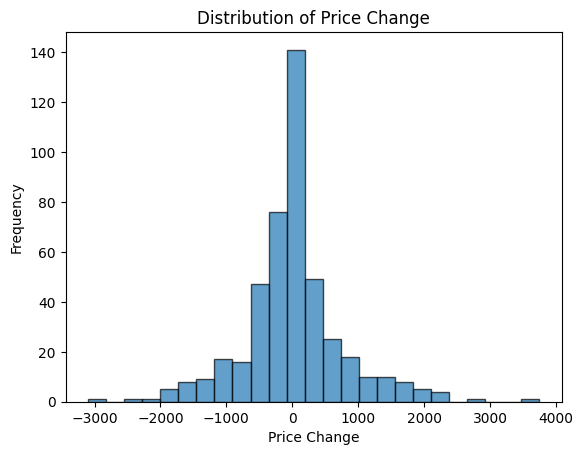

In [10]:
plt.hist(df['price_change'], bins=25, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.title('Distribution of Price Change')

# Display the plot
plt.show()

In [21]:
len(df[df['price_change'] > 330])

95

In [22]:
len(df[(df['price_change'] < 330) & (df['price_change'] > 0)])

123

In [23]:
len(df[df['price_change'] < 0])

235

In [24]:
len(df[(df['price_change'] > -330) & (df['price_change'] < 0)])

124

In [25]:
len(df[df['price_change'] < -330])

111

In [11]:
# Create bins
bins = [float("-inf"), -330, 0., 330, float("inf")]
labels = [0, 1, 2, 3]

# Put records into bins
df['price_change'] = pd.cut(x=df['price_change'], bins=bins, labels=labels, include_lowest=True)
df

,date,negative,positive,compound,daily_count,lagged_close,price_change,price_direction
278,2018-08-28,0.007695,0.028635,0.062261,750,7361.660156,2,positive
279,2018-08-29,0.006276,0.028844,0.072007,736,6792.830078,1,negative
280,2018-08-30,0.009227,0.029736,0.064531,746,6529.169922,0,negative
281,2018-08-31,0.008908,0.027812,0.055598,682,6467.069824,0,negative
282,2018-09-01,0.008893,0.025307,0.049348,642,6225.979980,0,negative
...,...,...,...,...,...,...,...,...
726,2019-11-19,0.038151,0.093721,0.165424,43287,7218.371094,0,negative
727,2019-11-20,0.036158,0.099087,0.181522,42112,7531.663574,0,negative
728,2019-11-21,0.042986,0.096216,0.155917,47978,7463.105957,1,negative
729,2019-11-22,0.048450,0.090741,0.129012,51043,7761.243652,3,positive


In [12]:
df['price_change'].value_counts()

1    124
2    123
0    111
3     95
Name: price_change, dtype: int64

In [13]:
# Copying df for further manipulations
df_copy = df.copy()

In [14]:
features = ['price_change', 'lagged_close', 'positive', 'negative', 'daily_count']

In [15]:
df_copy = df_copy[features]

In [16]:
# Number of previous records to consider for every example (Window size)
n_lag = 3

# Number of features
n_features = len(features)

# Calculate total_features
total_features = n_lag * n_features

if(total_features == 0):
    total_features = n_features

In [17]:
def create_lagged_features(data, n_lagged_features=1, to_remove=1):
    variables = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    columns, names = list(), list()
    
    for i in range(n_lagged_features, 0, -1):
        columns.append(df.shift(i))
        names += [f'feature{j+1}(t-{i})' for j in range(variables)]

    for i in range(0, to_remove):
        columns.append(df.shift(-i))
        if i == 0:
            names += [f'feature{j+1}(t)' for j in range(variables)]
        else:
            names += [f'feature{j+1}(t+{i})' for j in range(variables)]
            
    prepped_df = pd.concat(columns, axis=1)
    prepped_df.columns = names
    
    # Drop rows with NaN values
    prepped_df.dropna(inplace=True)
        
    return prepped_df

In [18]:
# Create lagged data (previous data window) columns
lagged_data = create_lagged_features(df_copy, n_lag, 1)
lagged_data = lagged_data.reset_index()
lagged_data = lagged_data.drop(['index'], axis=1)

In [19]:
lagged_data

,feature1(t-3),feature2(t-3),feature3(t-3),feature4(t-3),feature5(t-3),feature1(t-2),feature2(t-2),feature3(t-2),feature4(t-2),feature5(t-2),feature1(t-1),feature2(t-1),feature3(t-1),feature4(t-1),feature5(t-1),feature1(t),feature2(t),feature3(t),feature4(t),feature5(t)
0,2,7361.660156,0.028635,0.007695,750.0,1,6792.830078,0.028844,0.006276,736.0,0,6529.169922,0.029736,0.009227,746.0,0,6467.069824,0.027812,0.008908,682
1,1,6792.830078,0.028844,0.006276,736.0,0,6529.169922,0.029736,0.009227,746.0,0,6467.069824,0.027812,0.008908,682.0,0,6225.979980,0.025307,0.008893,642
2,0,6529.169922,0.029736,0.009227,746.0,0,6467.069824,0.027812,0.008908,682.0,0,6225.979980,0.025307,0.008893,642.0,0,6300.859863,0.028598,0.010656,659
3,0,6467.069824,0.027812,0.008908,682.0,0,6225.979980,0.025307,0.008893,642.0,0,6300.859863,0.028598,0.010656,659.0,0,6329.700195,0.024956,0.009593,707
4,0,6225.979980,0.025307,0.008893,642.0,0,6300.859863,0.028598,0.010656,659.0,0,6329.700195,0.024956,0.009593,707.0,0,6321.200195,0.025445,0.006964,719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0,7397.796875,0.093754,0.039901,33199.0,0,7047.916992,0.092225,0.039410,33029.0,0,7146.133789,0.090824,0.037751,41172.0,0,7218.371094,0.093721,0.038151,43287
446,0,7047.916992,0.092225,0.039410,33029.0,0,7146.133789,0.090824,0.037751,41172.0,0,7218.371094,0.093721,0.038151,43287.0,0,7531.663574,0.099087,0.036158,42112
447,0,7146.133789,0.090824,0.037751,41172.0,0,7218.371094,0.093721,0.038151,43287.0,0,7531.663574,0.099087,0.036158,42112.0,1,7463.105957,0.096216,0.042986,47978
448,0,7218.371094,0.093721,0.038151,43287.0,0,7531.663574,0.099087,0.036158,42112.0,1,7463.105957,0.096216,0.042986,47978.0,3,7761.243652,0.090741,0.048450,51043


In [44]:
X = lagged_data.iloc[:, :total_features].values
y = lagged_data['feature1(t)'].values

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)

In [46]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (382, 15) (382,)
Testing set shape: (68, 15) (68,)


In [47]:
# Normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
X_train = xscaler.fit_transform(X_train)
X_test = xscaler.transform(X_test)

In [48]:
# Reshape to match LSTM input [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_lag, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lag, n_features))

In [49]:
X_train.shape

(382, 3, 5)

In [51]:
# Set two class values (1-hot method)
y_train = keras.utils.to_categorical(y_train, 4)

### LSTM Model

In [52]:
EPOCHS = 10000

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [54]:
y_eval = keras.utils.to_categorical(y_test, 4)

In [55]:
# Optimize hyperparameters
import optuna

In [56]:
np.random.seed(1) 
tf.random.set_seed(1)

In [57]:
def objective(trial):
    activation_funcs = ['relu', 'tanh', 'selu', 'swish']

    # Hyperparameters that will be changed
    activation_func_1 = trial.suggest_categorical('activation_func_1', activation_funcs)
    activation_func_2 = trial.suggest_categorical('activation_func_2', activation_funcs)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 80])
    dropout_1 = trial.suggest_categorical('dropout_1', [0.25, 0.5])
    dropout_2 = trial.suggest_categorical('dropout_2', [0.25, 0.5])
    neurons = trial.suggest_int('neurons', 64, 256, log=True)
    
    model = Sequential()
    model.add(Bidirectional(LSTM(
        neurons, 
        return_sequences=True, 
        input_shape=(X_train.shape[1], X_train.shape[2]),
        activation=activation_func_1)))
    model.add(Dropout(dropout_1))
    model.add(Bidirectional(LSTM(
        neurons, 
        return_sequences=False, 
        activation=activation_func_2)))
    model.add(Dropout(dropout_2))
    model.add(Dense(4, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
      
    model.fit(X_train, 
              y_train, 
              epochs=EPOCHS,
              batch_size=batch_size, 
              verbose=2, 
              shuffle=True,
              validation_split=0.2, 
              callbacks=[early_stopping])
    
    # Evaluate the model on the validation data
    validation_accuracy = model.evaluate(X_test, y_eval)[1]

    return validation_accuracy

In [58]:
import time

In [59]:
study = optuna.create_study(storage='sqlite:///db.sqlite3', 
                            study_name='BiLSTM_magnitude_change_7_day_lag_3_day_window',
                            direction='maximize')

start_time = time.time()

study.optimize(objective, n_trials=100)

elapsed_time = time.time() - start_time
print(f'Elapsed Time: {elapsed_time:.2f} seconds')

[I 2023-07-26 21:42:56,896] A new study created in RDB with name: BiLSTM_magnitude_change_7_day_lag_3_day_window


Epoch 1/10000
4/4 - 7s - loss: 1.3817 - accuracy: 0.3148 - val_loss: 1.3725 - val_accuracy: 0.3896 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3663 - accuracy: 0.4197 - val_loss: 1.3587 - val_accuracy: 0.4026 - 92ms/epoch - 23ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3544 - accuracy: 0.4721 - val_loss: 1.3413 - val_accuracy: 0.3896 - 97ms/epoch - 24ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3249 - accuracy: 0.4656 - val_loss: 1.3176 - val_accuracy: 0.4416 - 92ms/epoch - 23ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2971 - accuracy: 0.4984 - val_loss: 1.2861 - val_accuracy: 0.4545 - 87ms/epoch - 22ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2677 - accuracy: 0.5148 - val_loss: 1.2486 - val_accuracy: 0.4545 - 93ms/epoch - 23ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2173 - accuracy: 0.5246 - val_loss: 1.2091 - val_accuracy: 0.4545 - 97ms/epoch - 24ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1815 - accuracy: 0.5180 - val_loss: 1.1779 - val_accuracy: 0.4416 - 101ms/epoch - 25ms/step
Epoch 9/100

[I 2023-07-26 21:43:09,824] Trial 0 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 120}. Best is trial 0 with value: 0.6764705777168274.


Epoch 1/10000
4/4 - 5s - loss: 1.3830 - accuracy: 0.2754 - val_loss: 1.3822 - val_accuracy: 0.2727 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3767 - accuracy: 0.3967 - val_loss: 1.3767 - val_accuracy: 0.4156 - 61ms/epoch - 15ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3695 - accuracy: 0.4230 - val_loss: 1.3702 - val_accuracy: 0.4026 - 56ms/epoch - 14ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3627 - accuracy: 0.4852 - val_loss: 1.3621 - val_accuracy: 0.4156 - 58ms/epoch - 15ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3543 - accuracy: 0.5082 - val_loss: 1.3517 - val_accuracy: 0.4026 - 61ms/epoch - 15ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3391 - accuracy: 0.5443 - val_loss: 1.3390 - val_accuracy: 0.4026 - 61ms/epoch - 15ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3227 - accuracy: 0.5148 - val_loss: 1.3227 - val_accuracy: 0.4026 - 63ms/epoch - 16ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3015 - accuracy: 0.5213 - val_loss: 1.3023 - val_accuracy: 0.4286 - 62ms/epoch - 16ms/step
Epoch 9/1000

[I 2023-07-26 21:43:19,076] Trial 1 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 73}. Best is trial 1 with value: 0.7058823704719543.


Epoch 1/10000
5/5 - 7s - loss: 1.3777 - accuracy: 0.2918 - val_loss: 1.3724 - val_accuracy: 0.3117 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3592 - accuracy: 0.4459 - val_loss: 1.3581 - val_accuracy: 0.3636 - 80ms/epoch - 16ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3420 - accuracy: 0.4295 - val_loss: 1.3392 - val_accuracy: 0.3766 - 76ms/epoch - 15ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3152 - accuracy: 0.4426 - val_loss: 1.3153 - val_accuracy: 0.4026 - 75ms/epoch - 15ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2864 - accuracy: 0.4656 - val_loss: 1.2843 - val_accuracy: 0.4286 - 77ms/epoch - 15ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2530 - accuracy: 0.4984 - val_loss: 1.2468 - val_accuracy: 0.4416 - 80ms/epoch - 16ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2210 - accuracy: 0.5082 - val_loss: 1.2128 - val_accuracy: 0.4026 - 78ms/epoch - 16ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2007 - accuracy: 0.5082 - val_loss: 1.1816 - val_accuracy: 0.4805 - 80ms/epoch - 16ms/step
Epoch 9/1000

[I 2023-07-26 21:43:30,599] Trial 2 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 85}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 7s - loss: 1.3847 - accuracy: 0.3148 - val_loss: 1.3820 - val_accuracy: 0.3636 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3789 - accuracy: 0.3967 - val_loss: 1.3772 - val_accuracy: 0.3766 - 177ms/epoch - 44ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3726 - accuracy: 0.4754 - val_loss: 1.3717 - val_accuracy: 0.4026 - 174ms/epoch - 43ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3654 - accuracy: 0.4984 - val_loss: 1.3654 - val_accuracy: 0.3896 - 211ms/epoch - 53ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3566 - accuracy: 0.5279 - val_loss: 1.3575 - val_accuracy: 0.3896 - 256ms/epoch - 64ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3465 - accuracy: 0.5180 - val_loss: 1.3478 - val_accuracy: 0.4026 - 229ms/epoch - 57ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3326 - accuracy: 0.5148 - val_loss: 1.3362 - val_accuracy: 0.4026 - 231ms/epoch - 58ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3174 - accuracy: 0.5279 - val_loss: 1.3220 - val_accuracy: 0.3766 - 221ms/epoch - 55ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8955 - accuracy: 0.6689 - val_loss: 0.8939 - val_accuracy: 0.6623 - 211ms/epoch - 53ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8711 - accuracy: 0.6689 - val_loss: 0.8984 - val_accuracy: 0.6623 - 216ms/epoch - 54ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8979 - accuracy: 0.6721 - val_loss: 0.8963 - val_accuracy: 0.6623 - 234ms/epoch - 58ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9183 - accuracy: 0.6557 - val_loss: 0.8955 - val_accuracy: 0.6623 - 225ms/epoch - 56ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8814 - accuracy: 0.6689 - val_loss: 0.8965 - val_accuracy: 0.6494 - 232ms/epoch - 58ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8883 - accuracy: 0.6557 - val_loss: 0.8980 - val_accuracy: 0.6494 - 232ms/epoch - 58ms/step
3/3 [==============================] - 0s 8ms/step - loss: 0.7876 - accuracy: 0.7206


[I 2023-07-26 21:43:54,481] Trial 3 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 82}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 8s - loss: 1.3808 - accuracy: 0.3279 - val_loss: 1.3759 - val_accuracy: 0.3247 - 8s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3661 - accuracy: 0.3770 - val_loss: 1.3630 - val_accuracy: 0.3636 - 416ms/epoch - 104ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3456 - accuracy: 0.4066 - val_loss: 1.3435 - val_accuracy: 0.3766 - 429ms/epoch - 107ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3179 - accuracy: 0.4197 - val_loss: 1.3136 - val_accuracy: 0.3896 - 427ms/epoch - 107ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2761 - accuracy: 0.4820 - val_loss: 1.2732 - val_accuracy: 0.4286 - 462ms/epoch - 115ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2258 - accuracy: 0.5115 - val_loss: 1.2292 - val_accuracy: 0.4416 - 419ms/epoch - 105ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.1955 - accuracy: 0.5213 - val_loss: 1.2086 - val_accuracy: 0.4156 - 427ms/epoch - 107ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1707 - accuracy: 0.5279 - val_loss: 1.1896 - val_accuracy: 0.4416 - 439ms/epoch - 110ms/ste

[I 2023-07-26 21:44:17,649] Trial 4 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 249}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 7s - loss: 1.3538 - accuracy: 0.2459 - val_loss: 1.3122 - val_accuracy: 0.3247 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.2657 - accuracy: 0.4459 - val_loss: 1.2264 - val_accuracy: 0.4286 - 363ms/epoch - 91ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.1920 - accuracy: 0.5311 - val_loss: 1.1798 - val_accuracy: 0.4545 - 392ms/epoch - 98ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.1464 - accuracy: 0.5574 - val_loss: 1.1474 - val_accuracy: 0.4805 - 390ms/epoch - 98ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.1154 - accuracy: 0.5836 - val_loss: 1.0780 - val_accuracy: 0.4935 - 383ms/epoch - 96ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.0731 - accuracy: 0.5902 - val_loss: 1.0395 - val_accuracy: 0.5584 - 370ms/epoch - 93ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.0245 - accuracy: 0.6033 - val_loss: 1.0121 - val_accuracy: 0.5455 - 378ms/epoch - 94ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.9996 - accuracy: 0.6033 - val_loss: 0.9787 - val_accuracy: 0.5714 - 391ms/epoch - 98ms/step
Epoch

[I 2023-07-26 21:44:33,377] Trial 5 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'tanh', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 232}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 6s - loss: 1.3268 - accuracy: 0.3574 - val_loss: 1.2568 - val_accuracy: 0.4416 - 6s/epoch - 580ms/step
Epoch 2/10000
10/10 - 1s - loss: 1.1695 - accuracy: 0.5377 - val_loss: 1.1261 - val_accuracy: 0.4416 - 671ms/epoch - 67ms/step
Epoch 3/10000
10/10 - 1s - loss: 1.1052 - accuracy: 0.5508 - val_loss: 1.0910 - val_accuracy: 0.5584 - 694ms/epoch - 69ms/step
Epoch 4/10000
10/10 - 1s - loss: 1.0417 - accuracy: 0.6000 - val_loss: 1.0035 - val_accuracy: 0.5065 - 723ms/epoch - 72ms/step
Epoch 5/10000
10/10 - 1s - loss: 1.0108 - accuracy: 0.6197 - val_loss: 1.0341 - val_accuracy: 0.5455 - 723ms/epoch - 72ms/step
Epoch 6/10000
10/10 - 1s - loss: 1.0006 - accuracy: 0.6000 - val_loss: 0.9572 - val_accuracy: 0.5714 - 712ms/epoch - 71ms/step
Epoch 7/10000
10/10 - 1s - loss: 0.9469 - accuracy: 0.6131 - val_loss: 0.9073 - val_accuracy: 0.6364 - 696ms/epoch - 70ms/step
Epoch 8/10000
10/10 - 1s - loss: 0.9070 - accuracy: 0.6754 - val_loss: 0.9131 - val_accuracy: 0.6104 - 744ms/epoc

[I 2023-07-26 21:44:52,025] Trial 6 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 245}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
5/5 - 6s - loss: 1.3852 - accuracy: 0.2885 - val_loss: 1.3830 - val_accuracy: 0.4026 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3816 - accuracy: 0.4230 - val_loss: 1.3794 - val_accuracy: 0.3896 - 249ms/epoch - 50ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3775 - accuracy: 0.4590 - val_loss: 1.3744 - val_accuracy: 0.3896 - 251ms/epoch - 50ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3721 - accuracy: 0.4689 - val_loss: 1.3683 - val_accuracy: 0.3896 - 252ms/epoch - 50ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3646 - accuracy: 0.4984 - val_loss: 1.3602 - val_accuracy: 0.3766 - 253ms/epoch - 51ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3544 - accuracy: 0.4951 - val_loss: 1.3495 - val_accuracy: 0.3766 - 250ms/epoch - 50ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3437 - accuracy: 0.5016 - val_loss: 1.3360 - val_accuracy: 0.4026 - 251ms/epoch - 50ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.3248 - accuracy: 0.5311 - val_loss: 1.3192 - val_accuracy: 0.3896 - 249ms/epoch - 50ms/step
Epoch

Epoch 67/10000
5/5 - 0s - loss: 0.8925 - accuracy: 0.6656 - val_loss: 0.8906 - val_accuracy: 0.6623 - 269ms/epoch - 54ms/step
Epoch 68/10000
5/5 - 0s - loss: 0.8782 - accuracy: 0.6492 - val_loss: 0.8935 - val_accuracy: 0.6364 - 262ms/epoch - 52ms/step
Epoch 69/10000
5/5 - 0s - loss: 0.8584 - accuracy: 0.6426 - val_loss: 0.8950 - val_accuracy: 0.6364 - 256ms/epoch - 51ms/step
Epoch 70/10000
5/5 - 0s - loss: 0.8589 - accuracy: 0.6721 - val_loss: 0.8974 - val_accuracy: 0.6623 - 262ms/epoch - 52ms/step
Epoch 71/10000
5/5 - 0s - loss: 0.8764 - accuracy: 0.6820 - val_loss: 0.8928 - val_accuracy: 0.6494 - 265ms/epoch - 53ms/step
Epoch 72/10000
5/5 - 0s - loss: 0.9118 - accuracy: 0.6557 - val_loss: 0.8894 - val_accuracy: 0.6623 - 266ms/epoch - 53ms/step
Epoch 73/10000
5/5 - 0s - loss: 0.8609 - accuracy: 0.6590 - val_loss: 0.9038 - val_accuracy: 0.6104 - 266ms/epoch - 53ms/step
Epoch 74/10000
5/5 - 0s - loss: 0.8712 - accuracy: 0.6820 - val_loss: 0.8916 - val_accuracy: 0.6623 - 265ms/epoch - 53

[I 2023-07-26 21:45:21,287] Trial 7 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 78}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 9s - loss: 1.3640 - accuracy: 0.2459 - val_loss: 1.3369 - val_accuracy: 0.3377 - 9s/epoch - 863ms/step
Epoch 2/10000
10/10 - 1s - loss: 1.2788 - accuracy: 0.4918 - val_loss: 1.2276 - val_accuracy: 0.4286 - 1s/epoch - 115ms/step
Epoch 3/10000
10/10 - 1s - loss: 1.1716 - accuracy: 0.5311 - val_loss: 1.1650 - val_accuracy: 0.4545 - 1s/epoch - 108ms/step
Epoch 4/10000
10/10 - 1s - loss: 1.1179 - accuracy: 0.5672 - val_loss: 1.0847 - val_accuracy: 0.4675 - 1s/epoch - 108ms/step
Epoch 5/10000
10/10 - 1s - loss: 1.0629 - accuracy: 0.5869 - val_loss: 1.0439 - val_accuracy: 0.5584 - 1s/epoch - 114ms/step
Epoch 6/10000
10/10 - 1s - loss: 1.0379 - accuracy: 0.5902 - val_loss: 1.0195 - val_accuracy: 0.5325 - 1s/epoch - 107ms/step
Epoch 7/10000
10/10 - 1s - loss: 1.0150 - accuracy: 0.6098 - val_loss: 0.9956 - val_accuracy: 0.5455 - 1s/epoch - 105ms/step
Epoch 8/10000
10/10 - 1s - loss: 0.9793 - accuracy: 0.6230 - val_loss: 0.9700 - val_accuracy: 0.5844 - 1s/epoch - 105ms/step


[I 2023-07-26 21:45:52,814] Trial 8 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'tanh', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 211}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 8s - loss: 1.3834 - accuracy: 0.3410 - val_loss: 1.3740 - val_accuracy: 0.4286 - 8s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3630 - accuracy: 0.4754 - val_loss: 1.3603 - val_accuracy: 0.4286 - 448ms/epoch - 112ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3438 - accuracy: 0.5279 - val_loss: 1.3417 - val_accuracy: 0.4286 - 422ms/epoch - 106ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3203 - accuracy: 0.5148 - val_loss: 1.3169 - val_accuracy: 0.4286 - 387ms/epoch - 97ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2883 - accuracy: 0.5279 - val_loss: 1.2853 - val_accuracy: 0.4286 - 388ms/epoch - 97ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2545 - accuracy: 0.5344 - val_loss: 1.2494 - val_accuracy: 0.4286 - 407ms/epoch - 102ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2240 - accuracy: 0.5016 - val_loss: 1.2173 - val_accuracy: 0.4026 - 408ms/epoch - 102ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1841 - accuracy: 0.5115 - val_loss: 1.1983 - val_accuracy: 0.4416 - 378ms/epoch - 94ms/step
E

[I 2023-07-26 21:46:15,016] Trial 9 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 118}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
5/5 - 5s - loss: 1.3437 - accuracy: 0.3475 - val_loss: 1.3036 - val_accuracy: 0.4286 - 5s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 1.2498 - accuracy: 0.5148 - val_loss: 1.2220 - val_accuracy: 0.4156 - 188ms/epoch - 38ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.1907 - accuracy: 0.5377 - val_loss: 1.1721 - val_accuracy: 0.4156 - 201ms/epoch - 40ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.1473 - accuracy: 0.5443 - val_loss: 1.1415 - val_accuracy: 0.4545 - 202ms/epoch - 40ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.1088 - accuracy: 0.5574 - val_loss: 1.0924 - val_accuracy: 0.4805 - 208ms/epoch - 42ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.0776 - accuracy: 0.5574 - val_loss: 1.0558 - val_accuracy: 0.5195 - 208ms/epoch - 42ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.0551 - accuracy: 0.5738 - val_loss: 1.0331 - val_accuracy: 0.5065 - 212ms/epoch - 42ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.0239 - accuracy: 0.5705 - val_loss: 0.9965 - val_accuracy: 0.5195 - 213ms/epoch - 43ms/step
Epoch

[I 2023-07-26 21:46:25,768] Trial 10 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 96}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
5/5 - 8s - loss: 1.3849 - accuracy: 0.3049 - val_loss: 1.3821 - val_accuracy: 0.4156 - 8s/epoch - 2s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3805 - accuracy: 0.4361 - val_loss: 1.3777 - val_accuracy: 0.4545 - 203ms/epoch - 41ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3756 - accuracy: 0.4951 - val_loss: 1.3726 - val_accuracy: 0.4805 - 209ms/epoch - 42ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3685 - accuracy: 0.5213 - val_loss: 1.3669 - val_accuracy: 0.4545 - 204ms/epoch - 41ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3625 - accuracy: 0.5148 - val_loss: 1.3591 - val_accuracy: 0.5065 - 196ms/epoch - 39ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3527 - accuracy: 0.5180 - val_loss: 1.3496 - val_accuracy: 0.4805 - 195ms/epoch - 39ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3430 - accuracy: 0.5115 - val_loss: 1.3378 - val_accuracy: 0.4545 - 194ms/epoch - 39ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.3257 - accuracy: 0.5180 - val_loss: 1.3217 - val_accuracy: 0.4545 - 199ms/epoch - 40ms/step
Epoch

[I 2023-07-26 21:46:45,273] Trial 11 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 65}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
5/5 - 6s - loss: 1.3855 - accuracy: 0.3311 - val_loss: 1.3854 - val_accuracy: 0.3766 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3840 - accuracy: 0.4098 - val_loss: 1.3840 - val_accuracy: 0.3766 - 286ms/epoch - 57ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3827 - accuracy: 0.4623 - val_loss: 1.3824 - val_accuracy: 0.3896 - 293ms/epoch - 59ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3808 - accuracy: 0.4852 - val_loss: 1.3806 - val_accuracy: 0.3896 - 305ms/epoch - 61ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3780 - accuracy: 0.4820 - val_loss: 1.3782 - val_accuracy: 0.3896 - 308ms/epoch - 62ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3749 - accuracy: 0.4885 - val_loss: 1.3753 - val_accuracy: 0.3766 - 298ms/epoch - 60ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3707 - accuracy: 0.5016 - val_loss: 1.3719 - val_accuracy: 0.3896 - 311ms/epoch - 62ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.3659 - accuracy: 0.5148 - val_loss: 1.3674 - val_accuracy: 0.4156 - 293ms/epoch - 59ms/step
Epoch

Epoch 67/10000
5/5 - 0s - loss: 0.9105 - accuracy: 0.6525 - val_loss: 0.9372 - val_accuracy: 0.5714 - 299ms/epoch - 60ms/step
Epoch 68/10000
5/5 - 0s - loss: 0.9092 - accuracy: 0.6557 - val_loss: 0.9354 - val_accuracy: 0.5974 - 303ms/epoch - 61ms/step
Epoch 69/10000
5/5 - 0s - loss: 0.8953 - accuracy: 0.6525 - val_loss: 0.9293 - val_accuracy: 0.5974 - 303ms/epoch - 61ms/step
Epoch 70/10000
5/5 - 0s - loss: 0.9161 - accuracy: 0.6328 - val_loss: 0.9295 - val_accuracy: 0.6104 - 310ms/epoch - 62ms/step
Epoch 71/10000
5/5 - 0s - loss: 0.9000 - accuracy: 0.6623 - val_loss: 0.9280 - val_accuracy: 0.6104 - 302ms/epoch - 60ms/step
Epoch 72/10000
5/5 - 0s - loss: 0.9269 - accuracy: 0.6623 - val_loss: 0.9270 - val_accuracy: 0.5974 - 303ms/epoch - 61ms/step
Epoch 73/10000
5/5 - 0s - loss: 0.9122 - accuracy: 0.6525 - val_loss: 0.9286 - val_accuracy: 0.5974 - 304ms/epoch - 61ms/step
Epoch 74/10000
5/5 - 0s - loss: 0.9083 - accuracy: 0.6393 - val_loss: 0.9246 - val_accuracy: 0.6234 - 305ms/epoch - 61

[I 2023-07-26 21:47:24,044] Trial 12 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 81}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
5/5 - 8s - loss: 1.3791 - accuracy: 0.2918 - val_loss: 1.3715 - val_accuracy: 0.2987 - 8s/epoch - 2s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3506 - accuracy: 0.4295 - val_loss: 1.3505 - val_accuracy: 0.3766 - 256ms/epoch - 51ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3237 - accuracy: 0.4623 - val_loss: 1.3251 - val_accuracy: 0.4156 - 268ms/epoch - 54ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.2899 - accuracy: 0.5016 - val_loss: 1.2920 - val_accuracy: 0.4156 - 272ms/epoch - 54ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2499 - accuracy: 0.5082 - val_loss: 1.2523 - val_accuracy: 0.4026 - 272ms/epoch - 54ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2160 - accuracy: 0.5279 - val_loss: 1.2146 - val_accuracy: 0.4156 - 274ms/epoch - 55ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.1904 - accuracy: 0.5115 - val_loss: 1.1899 - val_accuracy: 0.4156 - 274ms/epoch - 55ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.1495 - accuracy: 0.5279 - val_loss: 1.1625 - val_accuracy: 0.4416 - 275ms/epoch - 55ms/step
Epoch

[I 2023-07-26 21:47:46,204] Trial 13 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 96}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 6s - loss: 1.3816 - accuracy: 0.3344 - val_loss: 1.3767 - val_accuracy: 0.3766 - 6s/epoch - 579ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3709 - accuracy: 0.4951 - val_loss: 1.3634 - val_accuracy: 0.4286 - 274ms/epoch - 27ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3533 - accuracy: 0.4951 - val_loss: 1.3434 - val_accuracy: 0.3896 - 306ms/epoch - 31ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3241 - accuracy: 0.4984 - val_loss: 1.3100 - val_accuracy: 0.4026 - 330ms/epoch - 33ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2748 - accuracy: 0.5016 - val_loss: 1.2564 - val_accuracy: 0.4156 - 332ms/epoch - 33ms/step
Epoch 6/10000
10/10 - 1s - loss: 1.2069 - accuracy: 0.5115 - val_loss: 1.1932 - val_accuracy: 0.3896 - 513ms/epoch - 51ms/step
Epoch 7/10000
10/10 - 1s - loss: 1.1666 - accuracy: 0.5279 - val_loss: 1.1530 - val_accuracy: 0.4026 - 553ms/epoch - 55ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1460 - accuracy: 0.5607 - val_loss: 1.1151 - val_accuracy: 0.4286 - 454ms/epoc

[I 2023-07-26 21:48:12,150] Trial 14 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 96}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 9s - loss: 1.3845 - accuracy: 0.3049 - val_loss: 1.3823 - val_accuracy: 0.4286 - 9s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3793 - accuracy: 0.4262 - val_loss: 1.3778 - val_accuracy: 0.3896 - 210ms/epoch - 52ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3744 - accuracy: 0.4820 - val_loss: 1.3726 - val_accuracy: 0.4286 - 226ms/epoch - 57ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3681 - accuracy: 0.5082 - val_loss: 1.3666 - val_accuracy: 0.4156 - 228ms/epoch - 57ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3605 - accuracy: 0.5115 - val_loss: 1.3592 - val_accuracy: 0.4026 - 233ms/epoch - 58ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3538 - accuracy: 0.5115 - val_loss: 1.3505 - val_accuracy: 0.4286 - 228ms/epoch - 57ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3416 - accuracy: 0.5213 - val_loss: 1.3399 - val_accuracy: 0.4026 - 228ms/epoch - 57ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3296 - accuracy: 0.5213 - val_loss: 1.3269 - val_accuracy: 0.4286 - 235ms/epoch - 59ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8921 - accuracy: 0.6525 - val_loss: 0.9087 - val_accuracy: 0.6494 - 226ms/epoch - 56ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8739 - accuracy: 0.6787 - val_loss: 0.9090 - val_accuracy: 0.6494 - 229ms/epoch - 57ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8809 - accuracy: 0.6787 - val_loss: 0.8971 - val_accuracy: 0.6623 - 255ms/epoch - 64ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8695 - accuracy: 0.6754 - val_loss: 0.8956 - val_accuracy: 0.6623 - 235ms/epoch - 59ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8847 - accuracy: 0.6754 - val_loss: 0.8951 - val_accuracy: 0.6623 - 226ms/epoch - 56ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8950 - accuracy: 0.6689 - val_loss: 0.9041 - val_accuracy: 0.6623 - 222ms/epoch - 56ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8752 - accuracy: 0.6721 - val_loss: 0.9153 - val_accuracy: 0.6623 - 224ms/epoch - 56ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8691 - accuracy: 0.6721 - val_loss: 0.9039 - val_accuracy: 0.6623 - 225ms/epoch - 56

[I 2023-07-26 21:48:39,974] Trial 15 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 68}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
5/5 - 7s - loss: 1.3612 - accuracy: 0.2885 - val_loss: 1.3356 - val_accuracy: 0.3377 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 1s - loss: 1.2909 - accuracy: 0.4820 - val_loss: 1.2665 - val_accuracy: 0.4416 - 552ms/epoch - 110ms/step
Epoch 3/10000
5/5 - 1s - loss: 1.2208 - accuracy: 0.5443 - val_loss: 1.2039 - val_accuracy: 0.4545 - 565ms/epoch - 113ms/step
Epoch 4/10000
5/5 - 1s - loss: 1.1785 - accuracy: 0.5475 - val_loss: 1.1638 - val_accuracy: 0.4675 - 567ms/epoch - 113ms/step
Epoch 5/10000
5/5 - 1s - loss: 1.1336 - accuracy: 0.5803 - val_loss: 1.1240 - val_accuracy: 0.4935 - 576ms/epoch - 115ms/step
Epoch 6/10000
5/5 - 1s - loss: 1.1008 - accuracy: 0.5803 - val_loss: 1.0885 - val_accuracy: 0.5195 - 565ms/epoch - 113ms/step
Epoch 7/10000
5/5 - 1s - loss: 1.0787 - accuracy: 0.6033 - val_loss: 1.0498 - val_accuracy: 0.5325 - 567ms/epoch - 113ms/step
Epoch 8/10000
5/5 - 1s - loss: 1.0481 - accuracy: 0.5672 - val_loss: 1.0171 - val_accuracy: 0.5325 - 577ms/epoch - 115ms/ste

[I 2023-07-26 21:49:05,116] Trial 16 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 152}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
5/5 - 6s - loss: 1.3822 - accuracy: 0.2623 - val_loss: 1.3778 - val_accuracy: 0.3247 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3691 - accuracy: 0.3672 - val_loss: 1.3676 - val_accuracy: 0.3247 - 281ms/epoch - 56ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3541 - accuracy: 0.3705 - val_loss: 1.3526 - val_accuracy: 0.3247 - 273ms/epoch - 55ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3338 - accuracy: 0.3869 - val_loss: 1.3287 - val_accuracy: 0.3506 - 303ms/epoch - 61ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2971 - accuracy: 0.4492 - val_loss: 1.2902 - val_accuracy: 0.3896 - 274ms/epoch - 55ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2483 - accuracy: 0.4885 - val_loss: 1.2365 - val_accuracy: 0.4675 - 305ms/epoch - 61ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2048 - accuracy: 0.4951 - val_loss: 1.1881 - val_accuracy: 0.4545 - 326ms/epoch - 65ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.1489 - accuracy: 0.5607 - val_loss: 1.1543 - val_accuracy: 0.4545 - 314ms/epoch - 63ms/step
Epoch

[I 2023-07-26 21:49:21,925] Trial 17 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 84}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 7s - loss: 1.3866 - accuracy: 0.3180 - val_loss: 1.3784 - val_accuracy: 0.2857 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3738 - accuracy: 0.4131 - val_loss: 1.3689 - val_accuracy: 0.3896 - 174ms/epoch - 44ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3608 - accuracy: 0.4525 - val_loss: 1.3574 - val_accuracy: 0.3896 - 180ms/epoch - 45ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3453 - accuracy: 0.4525 - val_loss: 1.3435 - val_accuracy: 0.3636 - 168ms/epoch - 42ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3281 - accuracy: 0.4492 - val_loss: 1.3264 - val_accuracy: 0.3636 - 161ms/epoch - 40ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3075 - accuracy: 0.4623 - val_loss: 1.3069 - val_accuracy: 0.3766 - 169ms/epoch - 42ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2807 - accuracy: 0.4852 - val_loss: 1.2842 - val_accuracy: 0.3766 - 171ms/epoch - 43ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2488 - accuracy: 0.4918 - val_loss: 1.2603 - val_accuracy: 0.3766 - 172ms/epoch - 43ms/step
Epoch

[I 2023-07-26 21:49:38,002] Trial 18 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.25, 'neurons': 65}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
10/10 - 8s - loss: 1.3817 - accuracy: 0.3148 - val_loss: 1.3769 - val_accuracy: 0.3247 - 8s/epoch - 821ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3690 - accuracy: 0.4689 - val_loss: 1.3648 - val_accuracy: 0.4286 - 429ms/epoch - 43ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3526 - accuracy: 0.5311 - val_loss: 1.3459 - val_accuracy: 0.4026 - 436ms/epoch - 44ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3277 - accuracy: 0.5115 - val_loss: 1.3141 - val_accuracy: 0.3896 - 436ms/epoch - 44ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2792 - accuracy: 0.5443 - val_loss: 1.2633 - val_accuracy: 0.4026 - 439ms/epoch - 44ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2126 - accuracy: 0.5180 - val_loss: 1.2026 - val_accuracy: 0.4416 - 432ms/epoch - 43ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1784 - accuracy: 0.5246 - val_loss: 1.1606 - val_accuracy: 0.4286 - 437ms/epoch - 44ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1396 - accuracy: 0.5213 - val_loss: 1.1169 - val_accuracy: 0.4286 - 435ms/epoc

[I 2023-07-26 21:50:12,706] Trial 19 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 89}. Best is trial 2 with value: 0.720588207244873.


Epoch 1/10000
4/4 - 6s - loss: 1.3847 - accuracy: 0.3279 - val_loss: 1.3832 - val_accuracy: 0.4286 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3823 - accuracy: 0.3803 - val_loss: 1.3804 - val_accuracy: 0.3636 - 281ms/epoch - 70ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3773 - accuracy: 0.4721 - val_loss: 1.3773 - val_accuracy: 0.3896 - 265ms/epoch - 66ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3744 - accuracy: 0.4590 - val_loss: 1.3737 - val_accuracy: 0.3896 - 269ms/epoch - 67ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3693 - accuracy: 0.4820 - val_loss: 1.3693 - val_accuracy: 0.3896 - 267ms/epoch - 67ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3641 - accuracy: 0.5082 - val_loss: 1.3638 - val_accuracy: 0.4026 - 274ms/epoch - 69ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3554 - accuracy: 0.4984 - val_loss: 1.3571 - val_accuracy: 0.4026 - 267ms/epoch - 67ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3474 - accuracy: 0.5180 - val_loss: 1.3490 - val_accuracy: 0.4026 - 271ms/epoch - 68ms/step
Epoch

[I 2023-07-26 21:50:37,551] Trial 20 finished with value: 0.75 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 74}. Best is trial 20 with value: 0.75.


Epoch 1/10000
4/4 - 6s - loss: 1.3854 - accuracy: 0.3115 - val_loss: 1.3838 - val_accuracy: 0.4545 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3825 - accuracy: 0.4098 - val_loss: 1.3814 - val_accuracy: 0.4675 - 241ms/epoch - 60ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3784 - accuracy: 0.5082 - val_loss: 1.3783 - val_accuracy: 0.4935 - 256ms/epoch - 64ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3755 - accuracy: 0.4787 - val_loss: 1.3749 - val_accuracy: 0.5455 - 257ms/epoch - 64ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3714 - accuracy: 0.4852 - val_loss: 1.3708 - val_accuracy: 0.4935 - 262ms/epoch - 65ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3653 - accuracy: 0.5148 - val_loss: 1.3661 - val_accuracy: 0.5195 - 261ms/epoch - 65ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3594 - accuracy: 0.4984 - val_loss: 1.3607 - val_accuracy: 0.5065 - 260ms/epoch - 65ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3524 - accuracy: 0.5311 - val_loss: 1.3542 - val_accuracy: 0.5195 - 259ms/epoch - 65ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9202 - accuracy: 0.6426 - val_loss: 0.9163 - val_accuracy: 0.6494 - 261ms/epoch - 65ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8961 - accuracy: 0.6557 - val_loss: 0.9144 - val_accuracy: 0.6494 - 257ms/epoch - 64ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8900 - accuracy: 0.6525 - val_loss: 0.9111 - val_accuracy: 0.6234 - 265ms/epoch - 66ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9084 - accuracy: 0.6328 - val_loss: 0.9115 - val_accuracy: 0.6234 - 265ms/epoch - 66ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9042 - accuracy: 0.6525 - val_loss: 0.9121 - val_accuracy: 0.6234 - 260ms/epoch - 65ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9042 - accuracy: 0.6721 - val_loss: 0.9139 - val_accuracy: 0.6104 - 261ms/epoch - 65ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8897 - accuracy: 0.6656 - val_loss: 0.9211 - val_accuracy: 0.6104 - 259ms/epoch - 65ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8785 - accuracy: 0.6492 - val_loss: 0.9220 - val_accuracy: 0.6234 - 265ms/epoch - 66

[I 2023-07-26 21:51:03,738] Trial 21 finished with value: 0.7647058963775635 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 74}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3862 - accuracy: 0.3115 - val_loss: 1.3844 - val_accuracy: 0.3247 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3845 - accuracy: 0.3738 - val_loss: 1.3820 - val_accuracy: 0.3117 - 227ms/epoch - 57ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3808 - accuracy: 0.4000 - val_loss: 1.3792 - val_accuracy: 0.3766 - 242ms/epoch - 61ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3788 - accuracy: 0.4164 - val_loss: 1.3759 - val_accuracy: 0.3766 - 244ms/epoch - 61ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3733 - accuracy: 0.4131 - val_loss: 1.3720 - val_accuracy: 0.3896 - 239ms/epoch - 60ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3693 - accuracy: 0.4459 - val_loss: 1.3672 - val_accuracy: 0.3896 - 242ms/epoch - 60ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3642 - accuracy: 0.4656 - val_loss: 1.3616 - val_accuracy: 0.4026 - 253ms/epoch - 63ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3565 - accuracy: 0.4721 - val_loss: 1.3548 - val_accuracy: 0.4286 - 247ms/epoch - 62ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9186 - accuracy: 0.6623 - val_loss: 0.9054 - val_accuracy: 0.6104 - 241ms/epoch - 60ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9209 - accuracy: 0.6426 - val_loss: 0.9076 - val_accuracy: 0.5974 - 248ms/epoch - 62ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9093 - accuracy: 0.6656 - val_loss: 0.9073 - val_accuracy: 0.6104 - 239ms/epoch - 60ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9010 - accuracy: 0.6426 - val_loss: 0.9046 - val_accuracy: 0.6104 - 250ms/epoch - 62ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8963 - accuracy: 0.6492 - val_loss: 0.8990 - val_accuracy: 0.6234 - 246ms/epoch - 62ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9058 - accuracy: 0.6426 - val_loss: 0.8986 - val_accuracy: 0.6234 - 244ms/epoch - 61ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8803 - accuracy: 0.6590 - val_loss: 0.9059 - val_accuracy: 0.6104 - 243ms/epoch - 61ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9269 - accuracy: 0.6459 - val_loss: 0.9033 - val_accuracy: 0.6234 - 242ms/epoch - 60

[I 2023-07-26 21:51:33,591] Trial 22 finished with value: 0.75 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 70}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 7s - loss: 1.3850 - accuracy: 0.3574 - val_loss: 1.3836 - val_accuracy: 0.4286 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3817 - accuracy: 0.4525 - val_loss: 1.3809 - val_accuracy: 0.4286 - 258ms/epoch - 65ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3792 - accuracy: 0.5377 - val_loss: 1.3777 - val_accuracy: 0.4286 - 273ms/epoch - 68ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3757 - accuracy: 0.4885 - val_loss: 1.3741 - val_accuracy: 0.4286 - 274ms/epoch - 69ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3704 - accuracy: 0.4918 - val_loss: 1.3693 - val_accuracy: 0.4545 - 275ms/epoch - 69ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3649 - accuracy: 0.5377 - val_loss: 1.3636 - val_accuracy: 0.4805 - 278ms/epoch - 70ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3569 - accuracy: 0.5082 - val_loss: 1.3568 - val_accuracy: 0.4675 - 277ms/epoch - 69ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3483 - accuracy: 0.5311 - val_loss: 1.3482 - val_accuracy: 0.4545 - 279ms/epoch - 70ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9094 - accuracy: 0.6426 - val_loss: 0.8950 - val_accuracy: 0.6364 - 283ms/epoch - 71ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8995 - accuracy: 0.6393 - val_loss: 0.8936 - val_accuracy: 0.6364 - 289ms/epoch - 72ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8968 - accuracy: 0.6492 - val_loss: 0.8933 - val_accuracy: 0.6364 - 323ms/epoch - 81ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8933 - accuracy: 0.6426 - val_loss: 0.8975 - val_accuracy: 0.6364 - 359ms/epoch - 90ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9046 - accuracy: 0.6623 - val_loss: 0.8887 - val_accuracy: 0.6623 - 316ms/epoch - 79ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9168 - accuracy: 0.6557 - val_loss: 0.8870 - val_accuracy: 0.6623 - 319ms/epoch - 80ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8907 - accuracy: 0.6525 - val_loss: 0.8898 - val_accuracy: 0.6623 - 292ms/epoch - 73ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8610 - accuracy: 0.6689 - val_loss: 0.9013 - val_accuracy: 0.6623 - 322ms/epoch - 81

[I 2023-07-26 21:52:04,848] Trial 23 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 73}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3848 - accuracy: 0.3049 - val_loss: 1.3834 - val_accuracy: 0.3247 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3814 - accuracy: 0.4131 - val_loss: 1.3807 - val_accuracy: 0.4545 - 278ms/epoch - 70ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3779 - accuracy: 0.4426 - val_loss: 1.3773 - val_accuracy: 0.4805 - 283ms/epoch - 71ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3745 - accuracy: 0.4918 - val_loss: 1.3736 - val_accuracy: 0.4935 - 285ms/epoch - 71ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3715 - accuracy: 0.4885 - val_loss: 1.3690 - val_accuracy: 0.5195 - 283ms/epoch - 71ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3658 - accuracy: 0.4951 - val_loss: 1.3639 - val_accuracy: 0.5065 - 331ms/epoch - 83ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3574 - accuracy: 0.4820 - val_loss: 1.3579 - val_accuracy: 0.4675 - 316ms/epoch - 79ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3514 - accuracy: 0.5410 - val_loss: 1.3504 - val_accuracy: 0.4545 - 293ms/epoch - 73ms/step
Epoch

4/4 - 0s - loss: 0.9405 - accuracy: 0.6230 - val_loss: 0.9240 - val_accuracy: 0.6234 - 301ms/epoch - 75ms/step
Epoch 67/10000
4/4 - 0s - loss: 0.9187 - accuracy: 0.6426 - val_loss: 0.9195 - val_accuracy: 0.6234 - 296ms/epoch - 74ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9127 - accuracy: 0.6459 - val_loss: 0.9207 - val_accuracy: 0.6364 - 297ms/epoch - 74ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9157 - accuracy: 0.6525 - val_loss: 0.9127 - val_accuracy: 0.6364 - 292ms/epoch - 73ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8889 - accuracy: 0.6459 - val_loss: 0.9127 - val_accuracy: 0.6364 - 288ms/epoch - 72ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9110 - accuracy: 0.6459 - val_loss: 0.9080 - val_accuracy: 0.6364 - 285ms/epoch - 71ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8993 - accuracy: 0.6426 - val_loss: 0.9094 - val_accuracy: 0.6234 - 293ms/epoch - 73ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9256 - accuracy: 0.6361 - val_loss: 0.9190 - val_accuracy: 0.6234 - 285ms/epoch - 71ms/step
Epoch 7

[I 2023-07-26 21:52:37,091] Trial 24 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 73}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3866 - accuracy: 0.2689 - val_loss: 1.3845 - val_accuracy: 0.3896 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3838 - accuracy: 0.4066 - val_loss: 1.3822 - val_accuracy: 0.3766 - 248ms/epoch - 62ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3817 - accuracy: 0.4197 - val_loss: 1.3797 - val_accuracy: 0.3896 - 260ms/epoch - 65ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3791 - accuracy: 0.4623 - val_loss: 1.3769 - val_accuracy: 0.3896 - 263ms/epoch - 66ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3756 - accuracy: 0.4754 - val_loss: 1.3735 - val_accuracy: 0.3896 - 263ms/epoch - 66ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3701 - accuracy: 0.5049 - val_loss: 1.3693 - val_accuracy: 0.3896 - 264ms/epoch - 66ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3662 - accuracy: 0.4820 - val_loss: 1.3642 - val_accuracy: 0.3896 - 263ms/epoch - 66ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3585 - accuracy: 0.4984 - val_loss: 1.3579 - val_accuracy: 0.3896 - 261ms/epoch - 65ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9095 - accuracy: 0.6262 - val_loss: 0.9187 - val_accuracy: 0.6104 - 269ms/epoch - 67ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9153 - accuracy: 0.6590 - val_loss: 0.9129 - val_accuracy: 0.6104 - 267ms/epoch - 67ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8919 - accuracy: 0.6557 - val_loss: 0.9152 - val_accuracy: 0.6234 - 278ms/epoch - 69ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9141 - accuracy: 0.6492 - val_loss: 0.9234 - val_accuracy: 0.6104 - 321ms/epoch - 80ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9147 - accuracy: 0.6525 - val_loss: 0.9120 - val_accuracy: 0.6234 - 303ms/epoch - 76ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8923 - accuracy: 0.6525 - val_loss: 0.9115 - val_accuracy: 0.6104 - 285ms/epoch - 71ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8932 - accuracy: 0.6689 - val_loss: 0.9201 - val_accuracy: 0.6104 - 287ms/epoch - 72ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8943 - accuracy: 0.6361 - val_loss: 0.9263 - val_accuracy: 0.6234 - 270ms/epoch - 67

[I 2023-07-26 21:53:16,494] Trial 25 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 68}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3846 - accuracy: 0.2557 - val_loss: 1.3830 - val_accuracy: 0.3636 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3812 - accuracy: 0.4361 - val_loss: 1.3790 - val_accuracy: 0.4545 - 424ms/epoch - 106ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3755 - accuracy: 0.5475 - val_loss: 1.3739 - val_accuracy: 0.4805 - 423ms/epoch - 106ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3688 - accuracy: 0.5246 - val_loss: 1.3674 - val_accuracy: 0.4935 - 424ms/epoch - 106ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3600 - accuracy: 0.5213 - val_loss: 1.3593 - val_accuracy: 0.4935 - 420ms/epoch - 105ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3501 - accuracy: 0.5344 - val_loss: 1.3491 - val_accuracy: 0.4545 - 425ms/epoch - 106ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3345 - accuracy: 0.5475 - val_loss: 1.3366 - val_accuracy: 0.4545 - 418ms/epoch - 104ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3187 - accuracy: 0.5311 - val_loss: 1.3205 - val_accuracy: 0.4416 - 415ms/epoch - 104ms/ste

[I 2023-07-26 21:53:44,689] Trial 26 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 105}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3849 - accuracy: 0.3213 - val_loss: 1.3833 - val_accuracy: 0.3896 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3812 - accuracy: 0.4361 - val_loss: 1.3802 - val_accuracy: 0.4026 - 211ms/epoch - 53ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3776 - accuracy: 0.4557 - val_loss: 1.3766 - val_accuracy: 0.4026 - 230ms/epoch - 57ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3737 - accuracy: 0.4787 - val_loss: 1.3724 - val_accuracy: 0.3766 - 237ms/epoch - 59ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3680 - accuracy: 0.5016 - val_loss: 1.3675 - val_accuracy: 0.4286 - 231ms/epoch - 58ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3624 - accuracy: 0.5148 - val_loss: 1.3617 - val_accuracy: 0.4286 - 256ms/epoch - 64ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3564 - accuracy: 0.5082 - val_loss: 1.3545 - val_accuracy: 0.4156 - 246ms/epoch - 61ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3446 - accuracy: 0.5344 - val_loss: 1.3459 - val_accuracy: 0.4156 - 235ms/epoch - 59ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8985 - accuracy: 0.6754 - val_loss: 0.9072 - val_accuracy: 0.6623 - 250ms/epoch - 63ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9047 - accuracy: 0.6623 - val_loss: 0.9074 - val_accuracy: 0.6364 - 236ms/epoch - 59ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8830 - accuracy: 0.6623 - val_loss: 0.9053 - val_accuracy: 0.6104 - 238ms/epoch - 59ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9219 - accuracy: 0.6295 - val_loss: 0.9053 - val_accuracy: 0.6104 - 242ms/epoch - 60ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8878 - accuracy: 0.6590 - val_loss: 0.9023 - val_accuracy: 0.6364 - 239ms/epoch - 60ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8905 - accuracy: 0.6656 - val_loss: 0.9038 - val_accuracy: 0.6364 - 234ms/epoch - 58ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9120 - accuracy: 0.6328 - val_loss: 0.9109 - val_accuracy: 0.6364 - 249ms/epoch - 62ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8823 - accuracy: 0.6426 - val_loss: 0.9055 - val_accuracy: 0.6494 - 262ms/epoch - 66

[I 2023-07-26 21:54:11,460] Trial 27 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 74}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 7s - loss: 1.3857 - accuracy: 0.2852 - val_loss: 1.3831 - val_accuracy: 0.4156 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3830 - accuracy: 0.3934 - val_loss: 1.3804 - val_accuracy: 0.3896 - 194ms/epoch - 49ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3797 - accuracy: 0.4361 - val_loss: 1.3770 - val_accuracy: 0.3896 - 191ms/epoch - 48ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3760 - accuracy: 0.4459 - val_loss: 1.3729 - val_accuracy: 0.4026 - 193ms/epoch - 48ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3714 - accuracy: 0.4852 - val_loss: 1.3682 - val_accuracy: 0.3896 - 187ms/epoch - 47ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3653 - accuracy: 0.4951 - val_loss: 1.3625 - val_accuracy: 0.3766 - 186ms/epoch - 47ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3619 - accuracy: 0.5115 - val_loss: 1.3560 - val_accuracy: 0.4026 - 187ms/epoch - 47ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3507 - accuracy: 0.4984 - val_loss: 1.3481 - val_accuracy: 0.3896 - 191ms/epoch - 48ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9084 - accuracy: 0.6459 - val_loss: 0.9082 - val_accuracy: 0.6364 - 191ms/epoch - 48ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9027 - accuracy: 0.6459 - val_loss: 0.9046 - val_accuracy: 0.6234 - 191ms/epoch - 48ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8892 - accuracy: 0.6525 - val_loss: 0.9022 - val_accuracy: 0.6234 - 183ms/epoch - 46ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8920 - accuracy: 0.6361 - val_loss: 0.9057 - val_accuracy: 0.6364 - 192ms/epoch - 48ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8976 - accuracy: 0.6492 - val_loss: 0.9042 - val_accuracy: 0.6494 - 184ms/epoch - 46ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8825 - accuracy: 0.6590 - val_loss: 0.9026 - val_accuracy: 0.6494 - 185ms/epoch - 46ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8829 - accuracy: 0.6492 - val_loss: 0.9057 - val_accuracy: 0.6234 - 184ms/epoch - 46ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9052 - accuracy: 0.6590 - val_loss: 0.9038 - val_accuracy: 0.6364 - 193ms/epoch - 48

[I 2023-07-26 21:54:33,391] Trial 28 finished with value: 0.75 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3856 - accuracy: 0.2754 - val_loss: 1.3839 - val_accuracy: 0.3896 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3825 - accuracy: 0.4066 - val_loss: 1.3813 - val_accuracy: 0.4156 - 255ms/epoch - 64ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3796 - accuracy: 0.4590 - val_loss: 1.3784 - val_accuracy: 0.4156 - 293ms/epoch - 73ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3766 - accuracy: 0.4590 - val_loss: 1.3750 - val_accuracy: 0.4416 - 273ms/epoch - 68ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3704 - accuracy: 0.5082 - val_loss: 1.3706 - val_accuracy: 0.4026 - 298ms/epoch - 74ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3663 - accuracy: 0.4820 - val_loss: 1.3652 - val_accuracy: 0.4026 - 268ms/epoch - 67ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3593 - accuracy: 0.5148 - val_loss: 1.3585 - val_accuracy: 0.4156 - 283ms/epoch - 71ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3476 - accuracy: 0.5311 - val_loss: 1.3502 - val_accuracy: 0.4156 - 316ms/epoch - 79ms/step
Epoch

4/4 - 0s - loss: 0.8894 - accuracy: 0.6623 - val_loss: 0.9169 - val_accuracy: 0.5974 - 346ms/epoch - 86ms/step
Epoch 67/10000
4/4 - 0s - loss: 0.9053 - accuracy: 0.6459 - val_loss: 0.9206 - val_accuracy: 0.6104 - 323ms/epoch - 81ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8641 - accuracy: 0.6656 - val_loss: 0.9259 - val_accuracy: 0.6234 - 344ms/epoch - 86ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8859 - accuracy: 0.6590 - val_loss: 0.9160 - val_accuracy: 0.6234 - 363ms/epoch - 91ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9042 - accuracy: 0.6557 - val_loss: 0.9132 - val_accuracy: 0.6234 - 348ms/epoch - 87ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9201 - accuracy: 0.6754 - val_loss: 0.9060 - val_accuracy: 0.6364 - 326ms/epoch - 82ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9199 - accuracy: 0.6525 - val_loss: 0.9093 - val_accuracy: 0.6234 - 314ms/epoch - 78ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8916 - accuracy: 0.6656 - val_loss: 0.9239 - val_accuracy: 0.6234 - 294ms/epoch - 74ms/step
Epoch 7

[I 2023-07-26 21:55:02,807] Trial 29 finished with value: 0.75 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 77}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3866 - accuracy: 0.2525 - val_loss: 1.3815 - val_accuracy: 0.2597 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3786 - accuracy: 0.3213 - val_loss: 1.3762 - val_accuracy: 0.3377 - 354ms/epoch - 89ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3724 - accuracy: 0.3410 - val_loss: 1.3697 - val_accuracy: 0.3506 - 348ms/epoch - 87ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3650 - accuracy: 0.3770 - val_loss: 1.3611 - val_accuracy: 0.3896 - 350ms/epoch - 87ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3515 - accuracy: 0.4164 - val_loss: 1.3492 - val_accuracy: 0.4675 - 346ms/epoch - 87ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3391 - accuracy: 0.4361 - val_loss: 1.3338 - val_accuracy: 0.4545 - 348ms/epoch - 87ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3198 - accuracy: 0.4623 - val_loss: 1.3139 - val_accuracy: 0.4026 - 346ms/epoch - 87ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3043 - accuracy: 0.4393 - val_loss: 1.2892 - val_accuracy: 0.4026 - 349ms/epoch - 87ms/step
Epoch

[I 2023-07-26 21:55:32,753] Trial 30 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 89}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3856 - accuracy: 0.2426 - val_loss: 1.3837 - val_accuracy: 0.3636 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3831 - accuracy: 0.3180 - val_loss: 1.3810 - val_accuracy: 0.2987 - 182ms/epoch - 45ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3812 - accuracy: 0.3574 - val_loss: 1.3779 - val_accuracy: 0.3766 - 211ms/epoch - 53ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3771 - accuracy: 0.3869 - val_loss: 1.3745 - val_accuracy: 0.4286 - 206ms/epoch - 51ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3735 - accuracy: 0.4066 - val_loss: 1.3703 - val_accuracy: 0.4156 - 188ms/epoch - 47ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3692 - accuracy: 0.4754 - val_loss: 1.3656 - val_accuracy: 0.4026 - 184ms/epoch - 46ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3626 - accuracy: 0.4885 - val_loss: 1.3604 - val_accuracy: 0.4026 - 186ms/epoch - 47ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3561 - accuracy: 0.5082 - val_loss: 1.3545 - val_accuracy: 0.3766 - 193ms/epoch - 48ms/step
Epoch

[I 2023-07-26 21:55:52,300] Trial 31 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3841 - accuracy: 0.2492 - val_loss: 1.3835 - val_accuracy: 0.3117 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3820 - accuracy: 0.3311 - val_loss: 1.3807 - val_accuracy: 0.4026 - 227ms/epoch - 57ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3788 - accuracy: 0.3902 - val_loss: 1.3772 - val_accuracy: 0.3377 - 240ms/epoch - 60ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3747 - accuracy: 0.4262 - val_loss: 1.3733 - val_accuracy: 0.3506 - 251ms/epoch - 63ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3692 - accuracy: 0.4164 - val_loss: 1.3686 - val_accuracy: 0.3506 - 245ms/epoch - 61ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3642 - accuracy: 0.4459 - val_loss: 1.3632 - val_accuracy: 0.3636 - 245ms/epoch - 61ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3591 - accuracy: 0.4328 - val_loss: 1.3571 - val_accuracy: 0.3377 - 242ms/epoch - 61ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3486 - accuracy: 0.4262 - val_loss: 1.3494 - val_accuracy: 0.3377 - 245ms/epoch - 61ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9127 - accuracy: 0.6525 - val_loss: 0.9121 - val_accuracy: 0.6234 - 264ms/epoch - 66ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9005 - accuracy: 0.6492 - val_loss: 0.9110 - val_accuracy: 0.6234 - 268ms/epoch - 67ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9223 - accuracy: 0.6459 - val_loss: 0.9103 - val_accuracy: 0.6234 - 259ms/epoch - 65ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9261 - accuracy: 0.6393 - val_loss: 0.9153 - val_accuracy: 0.6104 - 261ms/epoch - 65ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8855 - accuracy: 0.6525 - val_loss: 0.9072 - val_accuracy: 0.6364 - 255ms/epoch - 64ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8848 - accuracy: 0.6426 - val_loss: 0.9110 - val_accuracy: 0.6234 - 261ms/epoch - 65ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8726 - accuracy: 0.6525 - val_loss: 0.9279 - val_accuracy: 0.6234 - 259ms/epoch - 65ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9041 - accuracy: 0.6623 - val_loss: 0.9127 - val_accuracy: 0.6364 - 257ms/epoch - 64

[I 2023-07-26 21:56:22,672] Trial 32 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 70}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3850 - accuracy: 0.2984 - val_loss: 1.3841 - val_accuracy: 0.4026 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3829 - accuracy: 0.3770 - val_loss: 1.3815 - val_accuracy: 0.3896 - 148ms/epoch - 37ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3799 - accuracy: 0.4361 - val_loss: 1.3785 - val_accuracy: 0.3896 - 156ms/epoch - 39ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3765 - accuracy: 0.4361 - val_loss: 1.3751 - val_accuracy: 0.3896 - 180ms/epoch - 45ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3733 - accuracy: 0.4623 - val_loss: 1.3710 - val_accuracy: 0.3896 - 171ms/epoch - 43ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3684 - accuracy: 0.4656 - val_loss: 1.3663 - val_accuracy: 0.4026 - 159ms/epoch - 40ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3652 - accuracy: 0.4590 - val_loss: 1.3610 - val_accuracy: 0.3766 - 160ms/epoch - 40ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3558 - accuracy: 0.4754 - val_loss: 1.3548 - val_accuracy: 0.3896 - 161ms/epoch - 40ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9165 - accuracy: 0.6393 - val_loss: 0.9153 - val_accuracy: 0.5974 - 159ms/epoch - 40ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9196 - accuracy: 0.6295 - val_loss: 0.9215 - val_accuracy: 0.5844 - 161ms/epoch - 40ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9070 - accuracy: 0.6426 - val_loss: 0.9201 - val_accuracy: 0.5974 - 161ms/epoch - 40ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9386 - accuracy: 0.6295 - val_loss: 0.9170 - val_accuracy: 0.6104 - 168ms/epoch - 42ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8986 - accuracy: 0.6590 - val_loss: 0.9093 - val_accuracy: 0.6104 - 161ms/epoch - 40ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9067 - accuracy: 0.6426 - val_loss: 0.9069 - val_accuracy: 0.6104 - 167ms/epoch - 42ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9109 - accuracy: 0.6197 - val_loss: 0.9132 - val_accuracy: 0.5974 - 163ms/epoch - 41ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9115 - accuracy: 0.6525 - val_loss: 0.9125 - val_accuracy: 0.6104 - 183ms/epoch - 46

[I 2023-07-26 21:56:46,772] Trial 33 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 8s - loss: 1.3863 - accuracy: 0.2557 - val_loss: 1.3842 - val_accuracy: 0.3896 - 8s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3836 - accuracy: 0.3672 - val_loss: 1.3817 - val_accuracy: 0.3896 - 316ms/epoch - 79ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3805 - accuracy: 0.4131 - val_loss: 1.3789 - val_accuracy: 0.3896 - 294ms/epoch - 73ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3768 - accuracy: 0.4721 - val_loss: 1.3756 - val_accuracy: 0.4156 - 297ms/epoch - 74ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3717 - accuracy: 0.5049 - val_loss: 1.3714 - val_accuracy: 0.4805 - 296ms/epoch - 74ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3681 - accuracy: 0.4885 - val_loss: 1.3663 - val_accuracy: 0.4805 - 307ms/epoch - 77ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3603 - accuracy: 0.4852 - val_loss: 1.3601 - val_accuracy: 0.4416 - 291ms/epoch - 73ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3526 - accuracy: 0.5016 - val_loss: 1.3526 - val_accuracy: 0.4675 - 302ms/epoch - 75ms/step
Epoch

[I 2023-07-26 21:57:15,124] Trial 34 finished with value: 0.75 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 74}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3817 - accuracy: 0.3115 - val_loss: 1.3797 - val_accuracy: 0.3766 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3749 - accuracy: 0.3639 - val_loss: 1.3725 - val_accuracy: 0.4156 - 289ms/epoch - 72ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3615 - accuracy: 0.4361 - val_loss: 1.3639 - val_accuracy: 0.3636 - 309ms/epoch - 77ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3477 - accuracy: 0.4525 - val_loss: 1.3525 - val_accuracy: 0.4156 - 302ms/epoch - 75ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3308 - accuracy: 0.4590 - val_loss: 1.3370 - val_accuracy: 0.4416 - 305ms/epoch - 76ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3091 - accuracy: 0.5016 - val_loss: 1.3167 - val_accuracy: 0.4416 - 312ms/epoch - 78ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2820 - accuracy: 0.5049 - val_loss: 1.2888 - val_accuracy: 0.4545 - 301ms/epoch - 75ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2457 - accuracy: 0.5246 - val_loss: 1.2516 - val_accuracy: 0.4416 - 306ms/epoch - 77ms/step
Epoch

[I 2023-07-26 21:57:37,452] Trial 35 finished with value: 0.6617646813392639 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 79}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3854 - accuracy: 0.2557 - val_loss: 1.3836 - val_accuracy: 0.4156 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3832 - accuracy: 0.3311 - val_loss: 1.3812 - val_accuracy: 0.3636 - 246ms/epoch - 62ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3814 - accuracy: 0.3705 - val_loss: 1.3783 - val_accuracy: 0.4286 - 243ms/epoch - 61ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3774 - accuracy: 0.4492 - val_loss: 1.3749 - val_accuracy: 0.4416 - 233ms/epoch - 58ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3743 - accuracy: 0.4230 - val_loss: 1.3705 - val_accuracy: 0.4416 - 245ms/epoch - 61ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3691 - accuracy: 0.4525 - val_loss: 1.3653 - val_accuracy: 0.4545 - 254ms/epoch - 63ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3631 - accuracy: 0.4787 - val_loss: 1.3592 - val_accuracy: 0.4156 - 274ms/epoch - 68ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3555 - accuracy: 0.4951 - val_loss: 1.3520 - val_accuracy: 0.4156 - 269ms/epoch - 67ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9042 - accuracy: 0.6656 - val_loss: 0.9222 - val_accuracy: 0.6104 - 263ms/epoch - 66ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9319 - accuracy: 0.6262 - val_loss: 0.9129 - val_accuracy: 0.6234 - 268ms/epoch - 67ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9638 - accuracy: 0.6230 - val_loss: 0.9128 - val_accuracy: 0.6104 - 294ms/epoch - 73ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8972 - accuracy: 0.6557 - val_loss: 0.9196 - val_accuracy: 0.6104 - 283ms/epoch - 71ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8999 - accuracy: 0.6623 - val_loss: 0.9162 - val_accuracy: 0.6104 - 275ms/epoch - 69ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9072 - accuracy: 0.6295 - val_loss: 0.9114 - val_accuracy: 0.6104 - 282ms/epoch - 71ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9006 - accuracy: 0.6590 - val_loss: 0.9132 - val_accuracy: 0.6104 - 244ms/epoch - 61ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9092 - accuracy: 0.6393 - val_loss: 0.9167 - val_accuracy: 0.6234 - 263ms/epoch - 66

[I 2023-07-26 21:58:05,425] Trial 36 finished with value: 0.75 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 69}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3869 - accuracy: 0.2754 - val_loss: 1.3729 - val_accuracy: 0.4026 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3625 - accuracy: 0.4164 - val_loss: 1.3538 - val_accuracy: 0.4286 - 258ms/epoch - 64ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3348 - accuracy: 0.4951 - val_loss: 1.3318 - val_accuracy: 0.4156 - 270ms/epoch - 68ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3059 - accuracy: 0.4885 - val_loss: 1.3063 - val_accuracy: 0.3896 - 267ms/epoch - 67ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.2732 - accuracy: 0.5279 - val_loss: 1.2770 - val_accuracy: 0.3896 - 277ms/epoch - 69ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.2401 - accuracy: 0.5213 - val_loss: 1.2472 - val_accuracy: 0.4026 - 266ms/epoch - 67ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2157 - accuracy: 0.5180 - val_loss: 1.2169 - val_accuracy: 0.4416 - 275ms/epoch - 69ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.1845 - accuracy: 0.5115 - val_loss: 1.1893 - val_accuracy: 0.4416 - 291ms/epoch - 73ms/step
Epoch

[I 2023-07-26 21:58:25,178] Trial 37 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 82}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 6s - loss: 1.3836 - accuracy: 0.3115 - val_loss: 1.3807 - val_accuracy: 0.5714 - 6s/epoch - 594ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3780 - accuracy: 0.4262 - val_loss: 1.3739 - val_accuracy: 0.4805 - 276ms/epoch - 28ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3683 - accuracy: 0.5213 - val_loss: 1.3628 - val_accuracy: 0.4935 - 296ms/epoch - 30ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3566 - accuracy: 0.4984 - val_loss: 1.3471 - val_accuracy: 0.4416 - 304ms/epoch - 30ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3322 - accuracy: 0.5016 - val_loss: 1.3229 - val_accuracy: 0.4545 - 281ms/epoch - 28ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3007 - accuracy: 0.5443 - val_loss: 1.2849 - val_accuracy: 0.4156 - 316ms/epoch - 32ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2572 - accuracy: 0.4885 - val_loss: 1.2321 - val_accuracy: 0.4026 - 335ms/epoch - 34ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1998 - accuracy: 0.5246 - val_loss: 1.1879 - val_accuracy: 0.4416 - 374ms/epoc

[I 2023-07-26 21:58:46,358] Trial 38 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 70}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 8s - loss: 1.3850 - accuracy: 0.3148 - val_loss: 1.3828 - val_accuracy: 0.3766 - 8s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3820 - accuracy: 0.4131 - val_loss: 1.3797 - val_accuracy: 0.3636 - 325ms/epoch - 81ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3780 - accuracy: 0.4820 - val_loss: 1.3757 - val_accuracy: 0.3636 - 389ms/epoch - 97ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3733 - accuracy: 0.4951 - val_loss: 1.3709 - val_accuracy: 0.3766 - 315ms/epoch - 79ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3676 - accuracy: 0.4820 - val_loss: 1.3650 - val_accuracy: 0.3896 - 342ms/epoch - 85ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3612 - accuracy: 0.4918 - val_loss: 1.3579 - val_accuracy: 0.3766 - 309ms/epoch - 77ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3522 - accuracy: 0.4754 - val_loss: 1.3493 - val_accuracy: 0.3896 - 321ms/epoch - 80ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3383 - accuracy: 0.4787 - val_loss: 1.3388 - val_accuracy: 0.4026 - 339ms/epoch - 85ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8802 - accuracy: 0.6590 - val_loss: 0.8881 - val_accuracy: 0.6623 - 397ms/epoch - 99ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8643 - accuracy: 0.6754 - val_loss: 0.8959 - val_accuracy: 0.6623 - 398ms/epoch - 100ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8757 - accuracy: 0.6623 - val_loss: 0.8951 - val_accuracy: 0.6494 - 420ms/epoch - 105ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8771 - accuracy: 0.6525 - val_loss: 0.8943 - val_accuracy: 0.6623 - 326ms/epoch - 81ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8495 - accuracy: 0.6689 - val_loss: 0.8903 - val_accuracy: 0.6623 - 328ms/epoch - 82ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8440 - accuracy: 0.6623 - val_loss: 0.8916 - val_accuracy: 0.6623 - 318ms/epoch - 80ms/step
3/3 [==============================] - 0s 8ms/step - loss: 0.7808 - accuracy: 0.7059


[I 2023-07-26 21:59:18,842] Trial 39 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 77}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 7s - loss: 1.3822 - accuracy: 0.3016 - val_loss: 1.3783 - val_accuracy: 0.3377 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3714 - accuracy: 0.3902 - val_loss: 1.3704 - val_accuracy: 0.3506 - 367ms/epoch - 92ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3616 - accuracy: 0.4295 - val_loss: 1.3598 - val_accuracy: 0.3377 - 388ms/epoch - 97ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3471 - accuracy: 0.4262 - val_loss: 1.3454 - val_accuracy: 0.3766 - 378ms/epoch - 94ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3275 - accuracy: 0.4197 - val_loss: 1.3253 - val_accuracy: 0.3766 - 385ms/epoch - 96ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3003 - accuracy: 0.4492 - val_loss: 1.2983 - val_accuracy: 0.4416 - 388ms/epoch - 97ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2657 - accuracy: 0.4852 - val_loss: 1.2623 - val_accuracy: 0.4545 - 380ms/epoch - 95ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2179 - accuracy: 0.5148 - val_loss: 1.2263 - val_accuracy: 0.4416 - 391ms/epoch - 98ms/step
Epoch

[I 2023-07-26 21:59:42,804] Trial 40 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 87}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3856 - accuracy: 0.3279 - val_loss: 1.3833 - val_accuracy: 0.3117 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3823 - accuracy: 0.3803 - val_loss: 1.3802 - val_accuracy: 0.3117 - 269ms/epoch - 67ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3800 - accuracy: 0.4098 - val_loss: 1.3765 - val_accuracy: 0.3766 - 269ms/epoch - 67ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3752 - accuracy: 0.4525 - val_loss: 1.3721 - val_accuracy: 0.3766 - 289ms/epoch - 72ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3697 - accuracy: 0.4820 - val_loss: 1.3664 - val_accuracy: 0.3896 - 283ms/epoch - 71ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3638 - accuracy: 0.4885 - val_loss: 1.3597 - val_accuracy: 0.4026 - 300ms/epoch - 75ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3564 - accuracy: 0.5049 - val_loss: 1.3519 - val_accuracy: 0.4026 - 269ms/epoch - 67ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3458 - accuracy: 0.5148 - val_loss: 1.3424 - val_accuracy: 0.4286 - 288ms/epoch - 72ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9043 - accuracy: 0.6492 - val_loss: 0.8992 - val_accuracy: 0.6623 - 303ms/epoch - 76ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8970 - accuracy: 0.6557 - val_loss: 0.9048 - val_accuracy: 0.6623 - 308ms/epoch - 77ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8721 - accuracy: 0.6721 - val_loss: 0.9039 - val_accuracy: 0.6234 - 314ms/epoch - 79ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9046 - accuracy: 0.6656 - val_loss: 0.9009 - val_accuracy: 0.6494 - 330ms/epoch - 82ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8851 - accuracy: 0.6721 - val_loss: 0.8919 - val_accuracy: 0.6623 - 306ms/epoch - 77ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8859 - accuracy: 0.6525 - val_loss: 0.8925 - val_accuracy: 0.6623 - 373ms/epoch - 93ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9011 - accuracy: 0.6656 - val_loss: 0.9072 - val_accuracy: 0.6494 - 333ms/epoch - 83ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8838 - accuracy: 0.6656 - val_loss: 0.9058 - val_accuracy: 0.6623 - 295ms/epoch - 74

[I 2023-07-26 22:00:13,986] Trial 41 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 77}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3853 - accuracy: 0.3246 - val_loss: 1.3841 - val_accuracy: 0.2987 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3830 - accuracy: 0.4066 - val_loss: 1.3814 - val_accuracy: 0.3117 - 233ms/epoch - 58ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3795 - accuracy: 0.4262 - val_loss: 1.3780 - val_accuracy: 0.3766 - 239ms/epoch - 60ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3757 - accuracy: 0.4689 - val_loss: 1.3741 - val_accuracy: 0.3766 - 251ms/epoch - 63ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3707 - accuracy: 0.4754 - val_loss: 1.3690 - val_accuracy: 0.3766 - 268ms/epoch - 67ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3643 - accuracy: 0.4689 - val_loss: 1.3630 - val_accuracy: 0.3766 - 285ms/epoch - 71ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3563 - accuracy: 0.4852 - val_loss: 1.3560 - val_accuracy: 0.3766 - 285ms/epoch - 71ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3498 - accuracy: 0.4852 - val_loss: 1.3479 - val_accuracy: 0.3896 - 244ms/epoch - 61ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8968 - accuracy: 0.6590 - val_loss: 0.8976 - val_accuracy: 0.6494 - 273ms/epoch - 68ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8882 - accuracy: 0.6557 - val_loss: 0.8941 - val_accuracy: 0.6494 - 294ms/epoch - 74ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9024 - accuracy: 0.6557 - val_loss: 0.8913 - val_accuracy: 0.6494 - 277ms/epoch - 69ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9018 - accuracy: 0.6426 - val_loss: 0.8966 - val_accuracy: 0.6364 - 258ms/epoch - 64ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8905 - accuracy: 0.6492 - val_loss: 0.8963 - val_accuracy: 0.6494 - 251ms/epoch - 63ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8882 - accuracy: 0.6656 - val_loss: 0.8959 - val_accuracy: 0.6623 - 243ms/epoch - 61ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8694 - accuracy: 0.6623 - val_loss: 0.9005 - val_accuracy: 0.6623 - 246ms/epoch - 61ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9150 - accuracy: 0.6656 - val_loss: 0.8986 - val_accuracy: 0.6623 - 256ms/epoch - 64

[I 2023-07-26 22:00:40,470] Trial 42 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 76}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3859 - accuracy: 0.2951 - val_loss: 1.3843 - val_accuracy: 0.3766 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3844 - accuracy: 0.3574 - val_loss: 1.3821 - val_accuracy: 0.3896 - 204ms/epoch - 51ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3820 - accuracy: 0.4000 - val_loss: 1.3794 - val_accuracy: 0.4026 - 213ms/epoch - 53ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3791 - accuracy: 0.4197 - val_loss: 1.3765 - val_accuracy: 0.4026 - 215ms/epoch - 54ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3758 - accuracy: 0.4098 - val_loss: 1.3730 - val_accuracy: 0.4026 - 231ms/epoch - 58ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3713 - accuracy: 0.4557 - val_loss: 1.3688 - val_accuracy: 0.3766 - 247ms/epoch - 62ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3667 - accuracy: 0.4951 - val_loss: 1.3637 - val_accuracy: 0.3896 - 220ms/epoch - 55ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3605 - accuracy: 0.4721 - val_loss: 1.3577 - val_accuracy: 0.3896 - 216ms/epoch - 54ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9270 - accuracy: 0.6459 - val_loss: 0.9078 - val_accuracy: 0.6104 - 284ms/epoch - 71ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9053 - accuracy: 0.6426 - val_loss: 0.9034 - val_accuracy: 0.6234 - 229ms/epoch - 57ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9225 - accuracy: 0.6525 - val_loss: 0.9040 - val_accuracy: 0.6104 - 222ms/epoch - 55ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9145 - accuracy: 0.6590 - val_loss: 0.9131 - val_accuracy: 0.6234 - 233ms/epoch - 58ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8922 - accuracy: 0.6623 - val_loss: 0.9044 - val_accuracy: 0.6104 - 236ms/epoch - 59ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9156 - accuracy: 0.6393 - val_loss: 0.9043 - val_accuracy: 0.6104 - 226ms/epoch - 57ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8906 - accuracy: 0.6525 - val_loss: 0.9066 - val_accuracy: 0.6104 - 215ms/epoch - 54ms/step
3/3 [==============================] - 0s 8ms/step - loss: 0.7832 - accuracy: 0.7353


[I 2023-07-26 22:01:04,695] Trial 43 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 68}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3856 - accuracy: 0.2656 - val_loss: 1.3830 - val_accuracy: 0.3506 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3792 - accuracy: 0.3705 - val_loss: 1.3788 - val_accuracy: 0.3896 - 310ms/epoch - 78ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3747 - accuracy: 0.4590 - val_loss: 1.3733 - val_accuracy: 0.4416 - 320ms/epoch - 80ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3664 - accuracy: 0.4525 - val_loss: 1.3656 - val_accuracy: 0.4286 - 288ms/epoch - 72ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3526 - accuracy: 0.5180 - val_loss: 1.3554 - val_accuracy: 0.4416 - 273ms/epoch - 68ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3463 - accuracy: 0.4984 - val_loss: 1.3427 - val_accuracy: 0.4416 - 280ms/epoch - 70ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3262 - accuracy: 0.5148 - val_loss: 1.3268 - val_accuracy: 0.4416 - 316ms/epoch - 79ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3038 - accuracy: 0.5279 - val_loss: 1.3078 - val_accuracy: 0.4286 - 307ms/epoch - 77ms/step
Epoch

[I 2023-07-26 22:01:28,528] Trial 44 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 81}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 7s - loss: 1.3835 - accuracy: 0.2590 - val_loss: 1.3786 - val_accuracy: 0.3247 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3732 - accuracy: 0.4295 - val_loss: 1.3694 - val_accuracy: 0.3896 - 253ms/epoch - 63ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3598 - accuracy: 0.4721 - val_loss: 1.3580 - val_accuracy: 0.3766 - 263ms/epoch - 66ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3454 - accuracy: 0.4951 - val_loss: 1.3436 - val_accuracy: 0.4026 - 253ms/epoch - 63ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3288 - accuracy: 0.4984 - val_loss: 1.3255 - val_accuracy: 0.4026 - 261ms/epoch - 65ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3080 - accuracy: 0.4984 - val_loss: 1.3042 - val_accuracy: 0.3896 - 256ms/epoch - 64ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2840 - accuracy: 0.4885 - val_loss: 1.2796 - val_accuracy: 0.4026 - 262ms/epoch - 66ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2485 - accuracy: 0.5082 - val_loss: 1.2525 - val_accuracy: 0.4026 - 252ms/epoch - 63ms/step
Epoch

[I 2023-07-26 22:01:49,076] Trial 45 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'selu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 71}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 6s - loss: 1.3841 - accuracy: 0.3180 - val_loss: 1.3820 - val_accuracy: 0.4026 - 6s/epoch - 585ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3796 - accuracy: 0.4230 - val_loss: 1.3773 - val_accuracy: 0.3896 - 248ms/epoch - 25ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3735 - accuracy: 0.4590 - val_loss: 1.3703 - val_accuracy: 0.4156 - 263ms/epoch - 26ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3635 - accuracy: 0.4820 - val_loss: 1.3601 - val_accuracy: 0.4026 - 256ms/epoch - 26ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3506 - accuracy: 0.4951 - val_loss: 1.3445 - val_accuracy: 0.4416 - 255ms/epoch - 26ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3279 - accuracy: 0.5279 - val_loss: 1.3197 - val_accuracy: 0.4286 - 264ms/epoch - 26ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2987 - accuracy: 0.5082 - val_loss: 1.2823 - val_accuracy: 0.4286 - 260ms/epoch - 26ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2523 - accuracy: 0.5115 - val_loss: 1.2407 - val_accuracy: 0.4545 - 256ms/epoc

[I 2023-07-26 22:02:08,535] Trial 46 finished with value: 0.7647058963775635 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 7s - loss: 1.3822 - accuracy: 0.3574 - val_loss: 1.3802 - val_accuracy: 0.3766 - 7s/epoch - 667ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3759 - accuracy: 0.5180 - val_loss: 1.3718 - val_accuracy: 0.4156 - 302ms/epoch - 30ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3665 - accuracy: 0.4984 - val_loss: 1.3600 - val_accuracy: 0.3636 - 354ms/epoch - 35ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3514 - accuracy: 0.5311 - val_loss: 1.3419 - val_accuracy: 0.3766 - 332ms/epoch - 33ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3268 - accuracy: 0.5148 - val_loss: 1.3146 - val_accuracy: 0.3896 - 425ms/epoch - 42ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2822 - accuracy: 0.5377 - val_loss: 1.2729 - val_accuracy: 0.3896 - 439ms/epoch - 44ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2334 - accuracy: 0.5148 - val_loss: 1.2221 - val_accuracy: 0.4026 - 354ms/epoch - 35ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1822 - accuracy: 0.5377 - val_loss: 1.1665 - val_accuracy: 0.4156 - 381ms/epoc

[I 2023-07-26 22:02:35,545] Trial 47 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 65}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 8s - loss: 1.3829 - accuracy: 0.3049 - val_loss: 1.3775 - val_accuracy: 0.2987 - 8s/epoch - 756ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3647 - accuracy: 0.4656 - val_loss: 1.3612 - val_accuracy: 0.4026 - 243ms/epoch - 24ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3417 - accuracy: 0.4918 - val_loss: 1.3347 - val_accuracy: 0.4416 - 263ms/epoch - 26ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3068 - accuracy: 0.4852 - val_loss: 1.2897 - val_accuracy: 0.4545 - 257ms/epoch - 26ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2456 - accuracy: 0.5213 - val_loss: 1.2254 - val_accuracy: 0.4545 - 248ms/epoch - 25ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1907 - accuracy: 0.5344 - val_loss: 1.1744 - val_accuracy: 0.4545 - 255ms/epoch - 25ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1790 - accuracy: 0.5443 - val_loss: 1.1384 - val_accuracy: 0.4545 - 255ms/epoch - 26ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1551 - accuracy: 0.5475 - val_loss: 1.1231 - val_accuracy: 0.4675 - 243ms/epoc

[I 2023-07-26 22:02:56,413] Trial 48 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 6s - loss: 1.3842 - accuracy: 0.3213 - val_loss: 1.3818 - val_accuracy: 0.3896 - 6s/epoch - 604ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3788 - accuracy: 0.4164 - val_loss: 1.3757 - val_accuracy: 0.3766 - 284ms/epoch - 28ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3702 - accuracy: 0.4656 - val_loss: 1.3661 - val_accuracy: 0.3766 - 299ms/epoch - 30ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3560 - accuracy: 0.4787 - val_loss: 1.3510 - val_accuracy: 0.4026 - 289ms/epoch - 29ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3369 - accuracy: 0.4918 - val_loss: 1.3279 - val_accuracy: 0.4026 - 294ms/epoch - 29ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3041 - accuracy: 0.4951 - val_loss: 1.2927 - val_accuracy: 0.4286 - 288ms/epoch - 29ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2657 - accuracy: 0.5115 - val_loss: 1.2461 - val_accuracy: 0.3896 - 290ms/epoch - 29ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2129 - accuracy: 0.5115 - val_loss: 1.2022 - val_accuracy: 0.4545 - 293ms/epoc

[I 2023-07-26 22:03:17,472] Trial 49 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 72}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 6s - loss: 1.3611 - accuracy: 0.3344 - val_loss: 1.3156 - val_accuracy: 0.3377 - 6s/epoch - 589ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.2671 - accuracy: 0.4885 - val_loss: 1.2440 - val_accuracy: 0.4416 - 288ms/epoch - 29ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.2064 - accuracy: 0.5279 - val_loss: 1.1906 - val_accuracy: 0.4545 - 299ms/epoch - 30ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.1540 - accuracy: 0.5639 - val_loss: 1.1348 - val_accuracy: 0.4805 - 282ms/epoch - 28ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.1278 - accuracy: 0.5607 - val_loss: 1.0885 - val_accuracy: 0.5325 - 284ms/epoch - 28ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.0881 - accuracy: 0.5738 - val_loss: 1.0600 - val_accuracy: 0.5325 - 296ms/epoch - 30ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.0586 - accuracy: 0.5738 - val_loss: 1.0431 - val_accuracy: 0.5584 - 330ms/epoch - 33ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.0344 - accuracy: 0.6033 - val_loss: 1.0086 - val_accuracy: 0.5974 - 307ms/epoc

[I 2023-07-26 22:03:30,502] Trial 50 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'selu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 68}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 7s - loss: 1.3844 - accuracy: 0.3180 - val_loss: 1.3810 - val_accuracy: 0.3636 - 7s/epoch - 738ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3785 - accuracy: 0.4066 - val_loss: 1.3739 - val_accuracy: 0.3766 - 437ms/epoch - 44ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3698 - accuracy: 0.4361 - val_loss: 1.3624 - val_accuracy: 0.3766 - 459ms/epoch - 46ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3557 - accuracy: 0.4918 - val_loss: 1.3457 - val_accuracy: 0.3636 - 417ms/epoch - 42ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3340 - accuracy: 0.4721 - val_loss: 1.3194 - val_accuracy: 0.4026 - 419ms/epoch - 42ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2961 - accuracy: 0.4852 - val_loss: 1.2800 - val_accuracy: 0.4156 - 414ms/epoch - 41ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2562 - accuracy: 0.4885 - val_loss: 1.2300 - val_accuracy: 0.4026 - 462ms/epoch - 46ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1983 - accuracy: 0.5049 - val_loss: 1.1924 - val_accuracy: 0.4545 - 411ms/epoc

[I 2023-07-26 22:03:58,874] Trial 51 finished with value: 0.7647058963775635 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 78}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 6s - loss: 1.3845 - accuracy: 0.3279 - val_loss: 1.3807 - val_accuracy: 0.2987 - 6s/epoch - 625ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3775 - accuracy: 0.4492 - val_loss: 1.3729 - val_accuracy: 0.3636 - 428ms/epoch - 43ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3674 - accuracy: 0.4590 - val_loss: 1.3613 - val_accuracy: 0.3766 - 447ms/epoch - 45ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3552 - accuracy: 0.4852 - val_loss: 1.3456 - val_accuracy: 0.3896 - 414ms/epoch - 41ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3346 - accuracy: 0.5246 - val_loss: 1.3215 - val_accuracy: 0.4026 - 417ms/epoch - 42ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2995 - accuracy: 0.5049 - val_loss: 1.2867 - val_accuracy: 0.3766 - 412ms/epoch - 41ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2689 - accuracy: 0.4918 - val_loss: 1.2418 - val_accuracy: 0.4026 - 417ms/epoch - 42ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2087 - accuracy: 0.5016 - val_loss: 1.2044 - val_accuracy: 0.4416 - 417ms/epoc

[I 2023-07-26 22:04:25,583] Trial 52 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 78}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 6s - loss: 1.3852 - accuracy: 0.2623 - val_loss: 1.3816 - val_accuracy: 0.3247 - 6s/epoch - 644ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3782 - accuracy: 0.4230 - val_loss: 1.3754 - val_accuracy: 0.4545 - 452ms/epoch - 45ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3688 - accuracy: 0.5082 - val_loss: 1.3647 - val_accuracy: 0.5065 - 458ms/epoch - 46ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3563 - accuracy: 0.5148 - val_loss: 1.3479 - val_accuracy: 0.5065 - 494ms/epoch - 49ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3295 - accuracy: 0.5279 - val_loss: 1.3203 - val_accuracy: 0.4935 - 466ms/epoch - 47ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2986 - accuracy: 0.5344 - val_loss: 1.2795 - val_accuracy: 0.4805 - 461ms/epoch - 46ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2595 - accuracy: 0.4754 - val_loss: 1.2279 - val_accuracy: 0.4286 - 451ms/epoch - 45ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2131 - accuracy: 0.5410 - val_loss: 1.1842 - val_accuracy: 0.4545 - 464ms/epoc

[I 2023-07-26 22:04:58,741] Trial 53 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 83}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 8s - loss: 1.3827 - accuracy: 0.4066 - val_loss: 1.3798 - val_accuracy: 0.3766 - 8s/epoch - 758ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3717 - accuracy: 0.5082 - val_loss: 1.3711 - val_accuracy: 0.4156 - 339ms/epoch - 34ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3593 - accuracy: 0.5180 - val_loss: 1.3575 - val_accuracy: 0.3896 - 336ms/epoch - 34ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3378 - accuracy: 0.5115 - val_loss: 1.3354 - val_accuracy: 0.3766 - 340ms/epoch - 34ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3039 - accuracy: 0.5115 - val_loss: 1.3029 - val_accuracy: 0.3896 - 342ms/epoch - 34ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2624 - accuracy: 0.4885 - val_loss: 1.2562 - val_accuracy: 0.4026 - 340ms/epoch - 34ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2185 - accuracy: 0.4852 - val_loss: 1.2085 - val_accuracy: 0.3636 - 336ms/epoch - 34ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1569 - accuracy: 0.4689 - val_loss: 1.1667 - val_accuracy: 0.4026 - 344ms/epoc

[I 2023-07-26 22:05:26,279] Trial 54 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 72}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 7s - loss: 1.3854 - accuracy: 0.3279 - val_loss: 1.3843 - val_accuracy: 0.4026 - 7s/epoch - 675ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3824 - accuracy: 0.4721 - val_loss: 1.3813 - val_accuracy: 0.3766 - 441ms/epoch - 44ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3785 - accuracy: 0.5016 - val_loss: 1.3772 - val_accuracy: 0.4026 - 457ms/epoch - 46ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3728 - accuracy: 0.5213 - val_loss: 1.3710 - val_accuracy: 0.3896 - 471ms/epoch - 47ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3633 - accuracy: 0.5213 - val_loss: 1.3605 - val_accuracy: 0.4416 - 445ms/epoch - 44ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3469 - accuracy: 0.5508 - val_loss: 1.3430 - val_accuracy: 0.4675 - 457ms/epoch - 46ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.3212 - accuracy: 0.5213 - val_loss: 1.3126 - val_accuracy: 0.4545 - 444ms/epoch - 44ms/step
Epoch 8/10000
10/10 - 1s - loss: 1.2755 - accuracy: 0.5213 - val_loss: 1.2703 - val_accuracy: 0.4545 - 507ms/epoc

[I 2023-07-26 22:06:00,078] Trial 55 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'swish', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 85}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 8s - loss: 1.3835 - accuracy: 0.3738 - val_loss: 1.3796 - val_accuracy: 0.4675 - 8s/epoch - 815ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3764 - accuracy: 0.4492 - val_loss: 1.3718 - val_accuracy: 0.3636 - 308ms/epoch - 31ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3657 - accuracy: 0.5016 - val_loss: 1.3601 - val_accuracy: 0.4545 - 314ms/epoch - 31ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3515 - accuracy: 0.5180 - val_loss: 1.3426 - val_accuracy: 0.4545 - 306ms/epoch - 31ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3277 - accuracy: 0.5311 - val_loss: 1.3151 - val_accuracy: 0.4416 - 350ms/epoch - 35ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2875 - accuracy: 0.5311 - val_loss: 1.2755 - val_accuracy: 0.4286 - 315ms/epoch - 31ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2479 - accuracy: 0.5279 - val_loss: 1.2282 - val_accuracy: 0.4545 - 307ms/epoch - 31ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1794 - accuracy: 0.5475 - val_loss: 1.1788 - val_accuracy: 0.4416 - 312ms/epoc

[I 2023-07-26 22:06:26,013] Trial 56 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 66}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
5/5 - 7s - loss: 1.3823 - accuracy: 0.3377 - val_loss: 1.3763 - val_accuracy: 0.4416 - 7s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3681 - accuracy: 0.4459 - val_loss: 1.3660 - val_accuracy: 0.4286 - 300ms/epoch - 60ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3561 - accuracy: 0.4721 - val_loss: 1.3536 - val_accuracy: 0.4545 - 306ms/epoch - 61ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3371 - accuracy: 0.4918 - val_loss: 1.3381 - val_accuracy: 0.4416 - 343ms/epoch - 69ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3130 - accuracy: 0.5279 - val_loss: 1.3185 - val_accuracy: 0.4286 - 346ms/epoch - 69ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2817 - accuracy: 0.5377 - val_loss: 1.2948 - val_accuracy: 0.4416 - 321ms/epoch - 64ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.2543 - accuracy: 0.5180 - val_loss: 1.2669 - val_accuracy: 0.4545 - 292ms/epoch - 58ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2171 - accuracy: 0.5246 - val_loss: 1.2389 - val_accuracy: 0.4416 - 293ms/epoch - 59ms/step
Epoch

[I 2023-07-26 22:06:54,137] Trial 57 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 68}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 6s - loss: 1.3817 - accuracy: 0.3246 - val_loss: 1.3758 - val_accuracy: 0.3766 - 6s/epoch - 571ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3675 - accuracy: 0.4295 - val_loss: 1.3615 - val_accuracy: 0.4416 - 389ms/epoch - 39ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3456 - accuracy: 0.4852 - val_loss: 1.3374 - val_accuracy: 0.4026 - 392ms/epoch - 39ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3107 - accuracy: 0.4656 - val_loss: 1.2943 - val_accuracy: 0.4416 - 399ms/epoch - 40ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.2542 - accuracy: 0.4754 - val_loss: 1.2279 - val_accuracy: 0.4156 - 407ms/epoch - 41ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1848 - accuracy: 0.4951 - val_loss: 1.1615 - val_accuracy: 0.4286 - 395ms/epoch - 39ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1596 - accuracy: 0.5344 - val_loss: 1.1126 - val_accuracy: 0.4805 - 389ms/epoch - 39ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1442 - accuracy: 0.5541 - val_loss: 1.0953 - val_accuracy: 0.5195 - 404ms/epoc

[I 2023-07-26 22:07:14,910] Trial 58 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 75}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
5/5 - 8s - loss: 1.3840 - accuracy: 0.3213 - val_loss: 1.3814 - val_accuracy: 0.3896 - 8s/epoch - 2s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3773 - accuracy: 0.4656 - val_loss: 1.3756 - val_accuracy: 0.4545 - 355ms/epoch - 71ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3696 - accuracy: 0.5180 - val_loss: 1.3685 - val_accuracy: 0.4416 - 390ms/epoch - 78ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3616 - accuracy: 0.5246 - val_loss: 1.3598 - val_accuracy: 0.4545 - 350ms/epoch - 70ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.3503 - accuracy: 0.5475 - val_loss: 1.3475 - val_accuracy: 0.4416 - 343ms/epoch - 69ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.3315 - accuracy: 0.5410 - val_loss: 1.3309 - val_accuracy: 0.4286 - 349ms/epoch - 70ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.3185 - accuracy: 0.5279 - val_loss: 1.3101 - val_accuracy: 0.4286 - 356ms/epoch - 71ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.2879 - accuracy: 0.5443 - val_loss: 1.2839 - val_accuracy: 0.4156 - 331ms/epoch - 66ms/step
Epoch

[I 2023-07-26 22:07:44,367] Trial 59 finished with value: 0.75 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 80}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 6s - loss: 1.3852 - accuracy: 0.2918 - val_loss: 1.3810 - val_accuracy: 0.4675 - 6s/epoch - 646ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3778 - accuracy: 0.4787 - val_loss: 1.3727 - val_accuracy: 0.4545 - 499ms/epoch - 50ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3660 - accuracy: 0.5180 - val_loss: 1.3601 - val_accuracy: 0.4286 - 485ms/epoch - 49ms/step
Epoch 4/10000
10/10 - 1s - loss: 1.3493 - accuracy: 0.5246 - val_loss: 1.3404 - val_accuracy: 0.4805 - 516ms/epoch - 52ms/step
Epoch 5/10000
10/10 - 1s - loss: 1.3216 - accuracy: 0.5508 - val_loss: 1.3091 - val_accuracy: 0.4675 - 534ms/epoch - 53ms/step
Epoch 6/10000
10/10 - 1s - loss: 1.2792 - accuracy: 0.5213 - val_loss: 1.2615 - val_accuracy: 0.4545 - 545ms/epoch - 54ms/step
Epoch 7/10000
10/10 - 1s - loss: 1.2400 - accuracy: 0.5115 - val_loss: 1.2065 - val_accuracy: 0.4545 - 511ms/epoch - 51ms/step
Epoch 8/10000
10/10 - 1s - loss: 1.1651 - accuracy: 0.5574 - val_loss: 1.1560 - val_accuracy: 0.4416 - 535ms/epoc

[I 2023-07-26 22:08:20,474] Trial 60 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 91}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3851 - accuracy: 0.2951 - val_loss: 1.3840 - val_accuracy: 0.3506 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3822 - accuracy: 0.4361 - val_loss: 1.3812 - val_accuracy: 0.3896 - 289ms/epoch - 72ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3787 - accuracy: 0.5049 - val_loss: 1.3777 - val_accuracy: 0.3896 - 288ms/epoch - 72ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3749 - accuracy: 0.5016 - val_loss: 1.3735 - val_accuracy: 0.3766 - 295ms/epoch - 74ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3705 - accuracy: 0.5213 - val_loss: 1.3683 - val_accuracy: 0.3896 - 294ms/epoch - 73ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3654 - accuracy: 0.5082 - val_loss: 1.3624 - val_accuracy: 0.4156 - 288ms/epoch - 72ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3575 - accuracy: 0.5279 - val_loss: 1.3560 - val_accuracy: 0.4156 - 299ms/epoch - 75ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3484 - accuracy: 0.5213 - val_loss: 1.3483 - val_accuracy: 0.4416 - 298ms/epoch - 74ms/step
Epoch

[I 2023-07-26 22:08:46,892] Trial 61 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 74}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 7s - loss: 1.3857 - accuracy: 0.2820 - val_loss: 1.3833 - val_accuracy: 0.3766 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3823 - accuracy: 0.3902 - val_loss: 1.3805 - val_accuracy: 0.3766 - 314ms/epoch - 79ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3795 - accuracy: 0.4787 - val_loss: 1.3772 - val_accuracy: 0.4026 - 327ms/epoch - 82ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3766 - accuracy: 0.4393 - val_loss: 1.3735 - val_accuracy: 0.4545 - 336ms/epoch - 84ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3716 - accuracy: 0.4590 - val_loss: 1.3690 - val_accuracy: 0.4675 - 333ms/epoch - 83ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3669 - accuracy: 0.5082 - val_loss: 1.3638 - val_accuracy: 0.4545 - 328ms/epoch - 82ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3614 - accuracy: 0.4984 - val_loss: 1.3577 - val_accuracy: 0.4805 - 307ms/epoch - 77ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3521 - accuracy: 0.5213 - val_loss: 1.3504 - val_accuracy: 0.5065 - 322ms/epoch - 80ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9163 - accuracy: 0.6328 - val_loss: 0.9040 - val_accuracy: 0.6104 - 302ms/epoch - 75ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9069 - accuracy: 0.6557 - val_loss: 0.9043 - val_accuracy: 0.6104 - 307ms/epoch - 77ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9068 - accuracy: 0.6492 - val_loss: 0.9063 - val_accuracy: 0.6104 - 300ms/epoch - 75ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9081 - accuracy: 0.6656 - val_loss: 0.9082 - val_accuracy: 0.6234 - 313ms/epoch - 78ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9019 - accuracy: 0.6557 - val_loss: 0.9041 - val_accuracy: 0.6104 - 299ms/epoch - 75ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8869 - accuracy: 0.6590 - val_loss: 0.9048 - val_accuracy: 0.6104 - 306ms/epoch - 77ms/step
3/3 [==============================] - 0s 8ms/step - loss: 0.7890 - accuracy: 0.7647


[I 2023-07-26 22:09:18,436] Trial 62 finished with value: 0.7647058963775635 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 70}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3860 - accuracy: 0.2721 - val_loss: 1.3844 - val_accuracy: 0.2987 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3830 - accuracy: 0.3738 - val_loss: 1.3820 - val_accuracy: 0.3896 - 263ms/epoch - 66ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3808 - accuracy: 0.4000 - val_loss: 1.3790 - val_accuracy: 0.3766 - 277ms/epoch - 69ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3776 - accuracy: 0.4098 - val_loss: 1.3755 - val_accuracy: 0.4026 - 275ms/epoch - 69ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3741 - accuracy: 0.4361 - val_loss: 1.3714 - val_accuracy: 0.4156 - 281ms/epoch - 70ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3687 - accuracy: 0.4754 - val_loss: 1.3665 - val_accuracy: 0.4156 - 274ms/epoch - 69ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3641 - accuracy: 0.4689 - val_loss: 1.3612 - val_accuracy: 0.4026 - 279ms/epoch - 70ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3553 - accuracy: 0.4623 - val_loss: 1.3549 - val_accuracy: 0.4026 - 283ms/epoch - 71ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9154 - accuracy: 0.6459 - val_loss: 0.9165 - val_accuracy: 0.6104 - 276ms/epoch - 69ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9100 - accuracy: 0.6557 - val_loss: 0.9138 - val_accuracy: 0.6104 - 284ms/epoch - 71ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9189 - accuracy: 0.6393 - val_loss: 0.9118 - val_accuracy: 0.6234 - 273ms/epoch - 68ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9438 - accuracy: 0.6328 - val_loss: 0.9160 - val_accuracy: 0.6104 - 284ms/epoch - 71ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9318 - accuracy: 0.6525 - val_loss: 0.9097 - val_accuracy: 0.6104 - 275ms/epoch - 69ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9176 - accuracy: 0.6361 - val_loss: 0.9076 - val_accuracy: 0.6104 - 301ms/epoch - 75ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9365 - accuracy: 0.6426 - val_loss: 0.9115 - val_accuracy: 0.6104 - 333ms/epoch - 83ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9071 - accuracy: 0.6557 - val_loss: 0.9164 - val_accuracy: 0.6234 - 338ms/epoch - 84

[I 2023-07-26 22:09:49,014] Trial 63 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 66}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3854 - accuracy: 0.2984 - val_loss: 1.3828 - val_accuracy: 0.4156 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3816 - accuracy: 0.4426 - val_loss: 1.3799 - val_accuracy: 0.3896 - 254ms/epoch - 63ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3788 - accuracy: 0.4590 - val_loss: 1.3765 - val_accuracy: 0.3896 - 277ms/epoch - 69ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3748 - accuracy: 0.4951 - val_loss: 1.3724 - val_accuracy: 0.4026 - 274ms/epoch - 68ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3690 - accuracy: 0.5049 - val_loss: 1.3670 - val_accuracy: 0.4026 - 275ms/epoch - 69ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3637 - accuracy: 0.4820 - val_loss: 1.3607 - val_accuracy: 0.4156 - 271ms/epoch - 68ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3555 - accuracy: 0.5279 - val_loss: 1.3531 - val_accuracy: 0.4156 - 278ms/epoch - 69ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3458 - accuracy: 0.5082 - val_loss: 1.3442 - val_accuracy: 0.4286 - 283ms/epoch - 71ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8997 - accuracy: 0.6426 - val_loss: 0.9173 - val_accuracy: 0.6234 - 272ms/epoch - 68ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9163 - accuracy: 0.6689 - val_loss: 0.9138 - val_accuracy: 0.6234 - 281ms/epoch - 70ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9147 - accuracy: 0.6426 - val_loss: 0.9119 - val_accuracy: 0.6104 - 275ms/epoch - 69ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9029 - accuracy: 0.6459 - val_loss: 0.9130 - val_accuracy: 0.6234 - 273ms/epoch - 68ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9249 - accuracy: 0.6525 - val_loss: 0.9056 - val_accuracy: 0.6494 - 271ms/epoch - 68ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9022 - accuracy: 0.6557 - val_loss: 0.9047 - val_accuracy: 0.6234 - 277ms/epoch - 69ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9059 - accuracy: 0.6656 - val_loss: 0.9077 - val_accuracy: 0.6234 - 274ms/epoch - 69ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9030 - accuracy: 0.6492 - val_loss: 0.9124 - val_accuracy: 0.6364 - 285ms/epoch - 71

[I 2023-07-26 22:10:18,289] Trial 64 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 71}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3856 - accuracy: 0.2787 - val_loss: 1.3841 - val_accuracy: 0.4545 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3824 - accuracy: 0.4295 - val_loss: 1.3817 - val_accuracy: 0.4935 - 240ms/epoch - 60ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3792 - accuracy: 0.4393 - val_loss: 1.3788 - val_accuracy: 0.4675 - 255ms/epoch - 64ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3769 - accuracy: 0.4393 - val_loss: 1.3758 - val_accuracy: 0.4416 - 253ms/epoch - 63ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3724 - accuracy: 0.4754 - val_loss: 1.3720 - val_accuracy: 0.4805 - 255ms/epoch - 64ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3683 - accuracy: 0.4787 - val_loss: 1.3678 - val_accuracy: 0.4805 - 273ms/epoch - 68ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3620 - accuracy: 0.5148 - val_loss: 1.3627 - val_accuracy: 0.4545 - 260ms/epoch - 65ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3524 - accuracy: 0.4721 - val_loss: 1.3566 - val_accuracy: 0.4675 - 256ms/epoch - 64ms/step
Epoch

[I 2023-07-26 22:10:41,264] Trial 65 finished with value: 0.75 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 67}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3861 - accuracy: 0.2918 - val_loss: 1.3838 - val_accuracy: 0.3247 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3828 - accuracy: 0.3639 - val_loss: 1.3808 - val_accuracy: 0.3896 - 185ms/epoch - 46ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3798 - accuracy: 0.4459 - val_loss: 1.3773 - val_accuracy: 0.4156 - 196ms/epoch - 49ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3760 - accuracy: 0.4230 - val_loss: 1.3732 - val_accuracy: 0.4026 - 207ms/epoch - 52ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3703 - accuracy: 0.4689 - val_loss: 1.3682 - val_accuracy: 0.4156 - 198ms/epoch - 50ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3659 - accuracy: 0.4721 - val_loss: 1.3626 - val_accuracy: 0.4286 - 191ms/epoch - 48ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3593 - accuracy: 0.4754 - val_loss: 1.3562 - val_accuracy: 0.3896 - 207ms/epoch - 52ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3508 - accuracy: 0.4918 - val_loss: 1.3480 - val_accuracy: 0.3896 - 221ms/epoch - 55ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9007 - accuracy: 0.6361 - val_loss: 0.9255 - val_accuracy: 0.6234 - 196ms/epoch - 49ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8966 - accuracy: 0.6525 - val_loss: 0.9224 - val_accuracy: 0.6364 - 198ms/epoch - 50ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8945 - accuracy: 0.6459 - val_loss: 0.9119 - val_accuracy: 0.6494 - 193ms/epoch - 48ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8793 - accuracy: 0.6557 - val_loss: 0.9126 - val_accuracy: 0.6623 - 193ms/epoch - 48ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9129 - accuracy: 0.6721 - val_loss: 0.9113 - val_accuracy: 0.6494 - 200ms/epoch - 50ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9005 - accuracy: 0.6590 - val_loss: 0.9126 - val_accuracy: 0.6494 - 195ms/epoch - 49ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8756 - accuracy: 0.6754 - val_loss: 0.9241 - val_accuracy: 0.6234 - 199ms/epoch - 50ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8818 - accuracy: 0.6689 - val_loss: 0.9322 - val_accuracy: 0.6364 - 194ms/epoch - 49

[I 2023-07-26 22:11:05,041] Trial 66 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 64}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 7s - loss: 1.3851 - accuracy: 0.3115 - val_loss: 1.3837 - val_accuracy: 0.3766 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3807 - accuracy: 0.4197 - val_loss: 1.3810 - val_accuracy: 0.3766 - 224ms/epoch - 56ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3791 - accuracy: 0.4557 - val_loss: 1.3777 - val_accuracy: 0.4286 - 266ms/epoch - 66ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3744 - accuracy: 0.4852 - val_loss: 1.3742 - val_accuracy: 0.4286 - 291ms/epoch - 73ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3690 - accuracy: 0.4918 - val_loss: 1.3702 - val_accuracy: 0.4286 - 243ms/epoch - 61ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3638 - accuracy: 0.5082 - val_loss: 1.3654 - val_accuracy: 0.4286 - 241ms/epoch - 60ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3583 - accuracy: 0.4984 - val_loss: 1.3596 - val_accuracy: 0.4416 - 248ms/epoch - 62ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3492 - accuracy: 0.5279 - val_loss: 1.3521 - val_accuracy: 0.4286 - 242ms/epoch - 61ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9001 - accuracy: 0.6721 - val_loss: 0.9083 - val_accuracy: 0.6234 - 243ms/epoch - 61ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9056 - accuracy: 0.6426 - val_loss: 0.9064 - val_accuracy: 0.6234 - 244ms/epoch - 61ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8836 - accuracy: 0.6557 - val_loss: 0.9030 - val_accuracy: 0.6234 - 246ms/epoch - 62ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8946 - accuracy: 0.6525 - val_loss: 0.9041 - val_accuracy: 0.6234 - 244ms/epoch - 61ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8735 - accuracy: 0.6689 - val_loss: 0.9010 - val_accuracy: 0.6364 - 240ms/epoch - 60ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8982 - accuracy: 0.6557 - val_loss: 0.9027 - val_accuracy: 0.6364 - 253ms/epoch - 63ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8779 - accuracy: 0.6557 - val_loss: 0.9123 - val_accuracy: 0.6364 - 245ms/epoch - 61ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9057 - accuracy: 0.6590 - val_loss: 0.9123 - val_accuracy: 0.6364 - 246ms/epoch - 62

[I 2023-07-26 22:11:35,965] Trial 67 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 70}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 8s - loss: 1.3834 - accuracy: 0.2787 - val_loss: 1.3805 - val_accuracy: 0.2338 - 8s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3765 - accuracy: 0.3508 - val_loss: 1.3740 - val_accuracy: 0.3636 - 277ms/epoch - 69ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3655 - accuracy: 0.4098 - val_loss: 1.3659 - val_accuracy: 0.3636 - 285ms/epoch - 71ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3537 - accuracy: 0.4459 - val_loss: 1.3554 - val_accuracy: 0.4026 - 291ms/epoch - 73ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3389 - accuracy: 0.5016 - val_loss: 1.3413 - val_accuracy: 0.4416 - 290ms/epoch - 72ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3235 - accuracy: 0.4787 - val_loss: 1.3218 - val_accuracy: 0.4545 - 299ms/epoch - 75ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.2953 - accuracy: 0.5049 - val_loss: 1.2945 - val_accuracy: 0.4545 - 295ms/epoch - 74ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2588 - accuracy: 0.5180 - val_loss: 1.2601 - val_accuracy: 0.4416 - 300ms/epoch - 75ms/step
Epoch

[I 2023-07-26 22:11:59,560] Trial 68 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 74}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
5/5 - 8s - loss: 1.3709 - accuracy: 0.2951 - val_loss: 1.3507 - val_accuracy: 0.3247 - 8s/epoch - 2s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3269 - accuracy: 0.4000 - val_loss: 1.3149 - val_accuracy: 0.3636 - 311ms/epoch - 62ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.2749 - accuracy: 0.4623 - val_loss: 1.2703 - val_accuracy: 0.4545 - 351ms/epoch - 70ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.2429 - accuracy: 0.5246 - val_loss: 1.2228 - val_accuracy: 0.4545 - 364ms/epoch - 73ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.1977 - accuracy: 0.5410 - val_loss: 1.1800 - val_accuracy: 0.4675 - 378ms/epoch - 76ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.1616 - accuracy: 0.5607 - val_loss: 1.1509 - val_accuracy: 0.4675 - 394ms/epoch - 79ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.1245 - accuracy: 0.5836 - val_loss: 1.1318 - val_accuracy: 0.4545 - 371ms/epoch - 74ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.1017 - accuracy: 0.5639 - val_loss: 1.1058 - val_accuracy: 0.5195 - 364ms/epoch - 73ms/step
Epoch

[I 2023-07-26 22:12:20,695] Trial 69 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 79}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3848 - accuracy: 0.2918 - val_loss: 1.3826 - val_accuracy: 0.3766 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3822 - accuracy: 0.4033 - val_loss: 1.3792 - val_accuracy: 0.4805 - 362ms/epoch - 91ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3778 - accuracy: 0.4951 - val_loss: 1.3754 - val_accuracy: 0.4805 - 384ms/epoch - 96ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3729 - accuracy: 0.4787 - val_loss: 1.3706 - val_accuracy: 0.4545 - 375ms/epoch - 94ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3668 - accuracy: 0.5148 - val_loss: 1.3649 - val_accuracy: 0.4805 - 388ms/epoch - 97ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3589 - accuracy: 0.5541 - val_loss: 1.3580 - val_accuracy: 0.4675 - 382ms/epoch - 95ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3505 - accuracy: 0.5410 - val_loss: 1.3496 - val_accuracy: 0.4545 - 377ms/epoch - 94ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3389 - accuracy: 0.5279 - val_loss: 1.3388 - val_accuracy: 0.4545 - 380ms/epoch - 95ms/step
Epoch

4/4 - 0s - loss: 0.8640 - accuracy: 0.6885 - val_loss: 0.9020 - val_accuracy: 0.6234 - 387ms/epoch - 97ms/step
Epoch 67/10000
4/4 - 0s - loss: 0.8846 - accuracy: 0.6525 - val_loss: 0.8954 - val_accuracy: 0.6494 - 380ms/epoch - 95ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8756 - accuracy: 0.6852 - val_loss: 0.8888 - val_accuracy: 0.6623 - 383ms/epoch - 96ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8799 - accuracy: 0.6623 - val_loss: 0.8856 - val_accuracy: 0.6623 - 406ms/epoch - 102ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9120 - accuracy: 0.6623 - val_loss: 0.8997 - val_accuracy: 0.6364 - 407ms/epoch - 102ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8624 - accuracy: 0.6820 - val_loss: 0.8936 - val_accuracy: 0.6494 - 380ms/epoch - 95ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8795 - accuracy: 0.6492 - val_loss: 0.8869 - val_accuracy: 0.6623 - 380ms/epoch - 95ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8917 - accuracy: 0.6557 - val_loss: 0.8928 - val_accuracy: 0.6494 - 388ms/epoch - 97ms/step
Epoch

[I 2023-07-26 22:12:56,762] Trial 70 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 85}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3856 - accuracy: 0.2656 - val_loss: 1.3843 - val_accuracy: 0.3636 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3833 - accuracy: 0.3705 - val_loss: 1.3816 - val_accuracy: 0.3896 - 248ms/epoch - 62ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3801 - accuracy: 0.4885 - val_loss: 1.3785 - val_accuracy: 0.4156 - 254ms/epoch - 63ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3763 - accuracy: 0.4951 - val_loss: 1.3751 - val_accuracy: 0.4026 - 282ms/epoch - 71ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3710 - accuracy: 0.5508 - val_loss: 1.3710 - val_accuracy: 0.4286 - 263ms/epoch - 66ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3677 - accuracy: 0.5049 - val_loss: 1.3658 - val_accuracy: 0.4416 - 253ms/epoch - 63ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3608 - accuracy: 0.5344 - val_loss: 1.3595 - val_accuracy: 0.4416 - 258ms/epoch - 64ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3496 - accuracy: 0.5180 - val_loss: 1.3516 - val_accuracy: 0.4416 - 266ms/epoch - 67ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8953 - accuracy: 0.6459 - val_loss: 0.9177 - val_accuracy: 0.6234 - 254ms/epoch - 63ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9109 - accuracy: 0.6492 - val_loss: 0.9095 - val_accuracy: 0.6234 - 289ms/epoch - 72ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8966 - accuracy: 0.6754 - val_loss: 0.9041 - val_accuracy: 0.6234 - 255ms/epoch - 64ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8812 - accuracy: 0.6525 - val_loss: 0.9064 - val_accuracy: 0.6234 - 255ms/epoch - 64ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8889 - accuracy: 0.6557 - val_loss: 0.9075 - val_accuracy: 0.6234 - 281ms/epoch - 70ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8964 - accuracy: 0.6492 - val_loss: 0.9091 - val_accuracy: 0.6234 - 261ms/epoch - 65ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8879 - accuracy: 0.6525 - val_loss: 0.9201 - val_accuracy: 0.6364 - 264ms/epoch - 66ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9222 - accuracy: 0.6689 - val_loss: 0.9100 - val_accuracy: 0.6623 - 255ms/epoch - 64

[I 2023-07-26 22:13:23,725] Trial 71 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 76}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3857 - accuracy: 0.2557 - val_loss: 1.3841 - val_accuracy: 0.2857 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3827 - accuracy: 0.4033 - val_loss: 1.3808 - val_accuracy: 0.4286 - 212ms/epoch - 53ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3796 - accuracy: 0.4787 - val_loss: 1.3773 - val_accuracy: 0.4156 - 248ms/epoch - 62ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3758 - accuracy: 0.5115 - val_loss: 1.3733 - val_accuracy: 0.4286 - 264ms/epoch - 66ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3708 - accuracy: 0.5246 - val_loss: 1.3683 - val_accuracy: 0.4286 - 300ms/epoch - 75ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3660 - accuracy: 0.5148 - val_loss: 1.3625 - val_accuracy: 0.4286 - 245ms/epoch - 61ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3600 - accuracy: 0.5213 - val_loss: 1.3556 - val_accuracy: 0.4286 - 231ms/epoch - 58ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3478 - accuracy: 0.5213 - val_loss: 1.3471 - val_accuracy: 0.4286 - 232ms/epoch - 58ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9018 - accuracy: 0.6557 - val_loss: 0.8994 - val_accuracy: 0.6364 - 253ms/epoch - 63ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9070 - accuracy: 0.6492 - val_loss: 0.8989 - val_accuracy: 0.6364 - 284ms/epoch - 71ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9328 - accuracy: 0.6426 - val_loss: 0.8994 - val_accuracy: 0.6364 - 272ms/epoch - 68ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9033 - accuracy: 0.6459 - val_loss: 0.9032 - val_accuracy: 0.6364 - 232ms/epoch - 58ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8916 - accuracy: 0.6393 - val_loss: 0.8962 - val_accuracy: 0.6623 - 241ms/epoch - 60ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9039 - accuracy: 0.6492 - val_loss: 0.8935 - val_accuracy: 0.6623 - 234ms/epoch - 59ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8860 - accuracy: 0.6557 - val_loss: 0.8959 - val_accuracy: 0.6364 - 253ms/epoch - 63ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9032 - accuracy: 0.6590 - val_loss: 0.8927 - val_accuracy: 0.6234 - 248ms/epoch - 62

[I 2023-07-26 22:13:50,267] Trial 72 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 71}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3844 - accuracy: 0.2951 - val_loss: 1.3838 - val_accuracy: 0.4416 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3816 - accuracy: 0.3770 - val_loss: 1.3809 - val_accuracy: 0.4156 - 222ms/epoch - 55ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3779 - accuracy: 0.4459 - val_loss: 1.3777 - val_accuracy: 0.4026 - 226ms/epoch - 57ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3734 - accuracy: 0.4984 - val_loss: 1.3741 - val_accuracy: 0.3896 - 254ms/epoch - 63ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3679 - accuracy: 0.5016 - val_loss: 1.3699 - val_accuracy: 0.3896 - 253ms/epoch - 63ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3637 - accuracy: 0.5180 - val_loss: 1.3651 - val_accuracy: 0.4156 - 236ms/epoch - 59ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3580 - accuracy: 0.5049 - val_loss: 1.3595 - val_accuracy: 0.4026 - 239ms/epoch - 60ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3496 - accuracy: 0.4885 - val_loss: 1.3527 - val_accuracy: 0.4026 - 231ms/epoch - 58ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9019 - accuracy: 0.6393 - val_loss: 0.9161 - val_accuracy: 0.6104 - 251ms/epoch - 63ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9115 - accuracy: 0.6426 - val_loss: 0.9151 - val_accuracy: 0.6234 - 248ms/epoch - 62ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9122 - accuracy: 0.6295 - val_loss: 0.9131 - val_accuracy: 0.6234 - 232ms/epoch - 58ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8924 - accuracy: 0.6492 - val_loss: 0.9116 - val_accuracy: 0.6234 - 231ms/epoch - 58ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9060 - accuracy: 0.6426 - val_loss: 0.9029 - val_accuracy: 0.6364 - 240ms/epoch - 60ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9069 - accuracy: 0.6492 - val_loss: 0.9013 - val_accuracy: 0.6364 - 233ms/epoch - 58ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9012 - accuracy: 0.6459 - val_loss: 0.9101 - val_accuracy: 0.6234 - 233ms/epoch - 58ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9049 - accuracy: 0.6590 - val_loss: 0.9169 - val_accuracy: 0.6234 - 234ms/epoch - 59

[I 2023-07-26 22:14:17,429] Trial 73 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 68}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3852 - accuracy: 0.2984 - val_loss: 1.3837 - val_accuracy: 0.4545 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3817 - accuracy: 0.4328 - val_loss: 1.3809 - val_accuracy: 0.4286 - 283ms/epoch - 71ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3780 - accuracy: 0.5016 - val_loss: 1.3775 - val_accuracy: 0.4416 - 301ms/epoch - 75ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3737 - accuracy: 0.4918 - val_loss: 1.3735 - val_accuracy: 0.4545 - 313ms/epoch - 78ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3682 - accuracy: 0.5016 - val_loss: 1.3684 - val_accuracy: 0.4545 - 271ms/epoch - 68ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3629 - accuracy: 0.4951 - val_loss: 1.3619 - val_accuracy: 0.4545 - 298ms/epoch - 74ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3543 - accuracy: 0.5443 - val_loss: 1.3542 - val_accuracy: 0.4416 - 289ms/epoch - 72ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3460 - accuracy: 0.5344 - val_loss: 1.3447 - val_accuracy: 0.4545 - 298ms/epoch - 75ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8952 - accuracy: 0.6689 - val_loss: 0.8871 - val_accuracy: 0.6623 - 291ms/epoch - 73ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9003 - accuracy: 0.6426 - val_loss: 0.8877 - val_accuracy: 0.6623 - 268ms/epoch - 67ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8701 - accuracy: 0.6623 - val_loss: 0.8802 - val_accuracy: 0.6623 - 295ms/epoch - 74ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8688 - accuracy: 0.6787 - val_loss: 0.8829 - val_accuracy: 0.6623 - 301ms/epoch - 75ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8668 - accuracy: 0.6721 - val_loss: 0.8858 - val_accuracy: 0.6623 - 286ms/epoch - 72ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9093 - accuracy: 0.6754 - val_loss: 0.8862 - val_accuracy: 0.6623 - 286ms/epoch - 71ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8863 - accuracy: 0.6754 - val_loss: 0.8923 - val_accuracy: 0.6623 - 272ms/epoch - 68ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8541 - accuracy: 0.6885 - val_loss: 0.8882 - val_accuracy: 0.6623 - 286ms/epoch - 72

[I 2023-07-26 22:14:46,001] Trial 74 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 81}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 8s - loss: 1.3852 - accuracy: 0.2787 - val_loss: 1.3832 - val_accuracy: 0.4026 - 8s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3823 - accuracy: 0.3607 - val_loss: 1.3801 - val_accuracy: 0.4026 - 304ms/epoch - 76ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3790 - accuracy: 0.4230 - val_loss: 1.3768 - val_accuracy: 0.4156 - 335ms/epoch - 84ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3743 - accuracy: 0.4820 - val_loss: 1.3727 - val_accuracy: 0.4286 - 315ms/epoch - 79ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3682 - accuracy: 0.4918 - val_loss: 1.3676 - val_accuracy: 0.3896 - 314ms/epoch - 78ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3622 - accuracy: 0.4918 - val_loss: 1.3612 - val_accuracy: 0.3896 - 317ms/epoch - 79ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3542 - accuracy: 0.5213 - val_loss: 1.3532 - val_accuracy: 0.4156 - 318ms/epoch - 80ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3418 - accuracy: 0.4984 - val_loss: 1.3437 - val_accuracy: 0.4156 - 318ms/epoch - 80ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9051 - accuracy: 0.6590 - val_loss: 0.9124 - val_accuracy: 0.6364 - 324ms/epoch - 81ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8988 - accuracy: 0.6459 - val_loss: 0.9155 - val_accuracy: 0.6364 - 325ms/epoch - 81ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9076 - accuracy: 0.6557 - val_loss: 0.9102 - val_accuracy: 0.6234 - 329ms/epoch - 82ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9044 - accuracy: 0.6656 - val_loss: 0.9104 - val_accuracy: 0.6234 - 354ms/epoch - 89ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8985 - accuracy: 0.6525 - val_loss: 0.9014 - val_accuracy: 0.6364 - 342ms/epoch - 85ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9196 - accuracy: 0.6262 - val_loss: 0.9044 - val_accuracy: 0.6364 - 325ms/epoch - 81ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9210 - accuracy: 0.6230 - val_loss: 0.9100 - val_accuracy: 0.6364 - 324ms/epoch - 81ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8952 - accuracy: 0.6656 - val_loss: 0.9053 - val_accuracy: 0.6494 - 317ms/epoch - 79

[I 2023-07-26 22:15:19,459] Trial 75 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 77}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3842 - accuracy: 0.2885 - val_loss: 1.3824 - val_accuracy: 0.3377 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3772 - accuracy: 0.4000 - val_loss: 1.3778 - val_accuracy: 0.4416 - 251ms/epoch - 63ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3714 - accuracy: 0.4590 - val_loss: 1.3721 - val_accuracy: 0.3896 - 257ms/epoch - 64ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3642 - accuracy: 0.4426 - val_loss: 1.3649 - val_accuracy: 0.4026 - 263ms/epoch - 66ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3548 - accuracy: 0.5213 - val_loss: 1.3558 - val_accuracy: 0.4156 - 257ms/epoch - 64ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3471 - accuracy: 0.4918 - val_loss: 1.3450 - val_accuracy: 0.4286 - 254ms/epoch - 63ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3351 - accuracy: 0.5049 - val_loss: 1.3316 - val_accuracy: 0.4286 - 260ms/epoch - 65ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3105 - accuracy: 0.5213 - val_loss: 1.3144 - val_accuracy: 0.4286 - 267ms/epoch - 67ms/step
Epoch

[I 2023-07-26 22:15:44,549] Trial 76 finished with value: 0.6764705777168274 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 66}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 8s - loss: 1.3854 - accuracy: 0.3410 - val_loss: 1.3824 - val_accuracy: 0.3636 - 8s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3803 - accuracy: 0.4066 - val_loss: 1.3784 - val_accuracy: 0.3377 - 345ms/epoch - 86ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3751 - accuracy: 0.4197 - val_loss: 1.3738 - val_accuracy: 0.4545 - 326ms/epoch - 81ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3689 - accuracy: 0.4721 - val_loss: 1.3685 - val_accuracy: 0.4416 - 292ms/epoch - 73ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3611 - accuracy: 0.4721 - val_loss: 1.3620 - val_accuracy: 0.4156 - 306ms/epoch - 76ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3547 - accuracy: 0.4754 - val_loss: 1.3543 - val_accuracy: 0.3896 - 313ms/epoch - 78ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3415 - accuracy: 0.5016 - val_loss: 1.3451 - val_accuracy: 0.3896 - 308ms/epoch - 77ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3317 - accuracy: 0.5016 - val_loss: 1.3340 - val_accuracy: 0.3766 - 298ms/epoch - 74ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8761 - accuracy: 0.6820 - val_loss: 0.9005 - val_accuracy: 0.6494 - 281ms/epoch - 70ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8838 - accuracy: 0.6689 - val_loss: 0.9039 - val_accuracy: 0.6623 - 284ms/epoch - 71ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8714 - accuracy: 0.6721 - val_loss: 0.9043 - val_accuracy: 0.6623 - 317ms/epoch - 79ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8937 - accuracy: 0.6787 - val_loss: 0.9031 - val_accuracy: 0.6623 - 292ms/epoch - 73ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8928 - accuracy: 0.6689 - val_loss: 0.8959 - val_accuracy: 0.6494 - 300ms/epoch - 75ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9003 - accuracy: 0.6525 - val_loss: 0.8967 - val_accuracy: 0.6494 - 296ms/epoch - 74ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8877 - accuracy: 0.6656 - val_loss: 0.9051 - val_accuracy: 0.6494 - 288ms/epoch - 72ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8858 - accuracy: 0.6689 - val_loss: 0.9033 - val_accuracy: 0.6623 - 331ms/epoch - 83

[I 2023-07-26 22:16:21,020] Trial 77 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 73}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 6s - loss: 1.3844 - accuracy: 0.3443 - val_loss: 1.3809 - val_accuracy: 0.4675 - 6s/epoch - 633ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3783 - accuracy: 0.4820 - val_loss: 1.3745 - val_accuracy: 0.4416 - 327ms/epoch - 33ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3700 - accuracy: 0.5148 - val_loss: 1.3649 - val_accuracy: 0.4675 - 337ms/epoch - 34ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3556 - accuracy: 0.5410 - val_loss: 1.3499 - val_accuracy: 0.4935 - 341ms/epoch - 34ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3300 - accuracy: 0.5541 - val_loss: 1.3242 - val_accuracy: 0.4545 - 341ms/epoch - 34ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2944 - accuracy: 0.5311 - val_loss: 1.2855 - val_accuracy: 0.4545 - 338ms/epoch - 34ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2565 - accuracy: 0.5115 - val_loss: 1.2381 - val_accuracy: 0.4286 - 343ms/epoch - 34ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1971 - accuracy: 0.5475 - val_loss: 1.1888 - val_accuracy: 0.4545 - 342ms/epoc

[I 2023-07-26 22:16:46,214] Trial 78 finished with value: 0.75 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 70}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3852 - accuracy: 0.2984 - val_loss: 1.3830 - val_accuracy: 0.3506 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3826 - accuracy: 0.3574 - val_loss: 1.3800 - val_accuracy: 0.4156 - 191ms/epoch - 48ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3800 - accuracy: 0.3803 - val_loss: 1.3769 - val_accuracy: 0.4026 - 209ms/epoch - 52ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3759 - accuracy: 0.4525 - val_loss: 1.3732 - val_accuracy: 0.4026 - 200ms/epoch - 50ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3712 - accuracy: 0.4590 - val_loss: 1.3684 - val_accuracy: 0.3896 - 200ms/epoch - 50ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3659 - accuracy: 0.5082 - val_loss: 1.3627 - val_accuracy: 0.3766 - 208ms/epoch - 52ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3599 - accuracy: 0.4951 - val_loss: 1.3562 - val_accuracy: 0.3766 - 197ms/epoch - 49ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3503 - accuracy: 0.5016 - val_loss: 1.3484 - val_accuracy: 0.3766 - 207ms/epoch - 52ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8984 - accuracy: 0.6459 - val_loss: 0.9171 - val_accuracy: 0.6234 - 201ms/epoch - 50ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8968 - accuracy: 0.6754 - val_loss: 0.9171 - val_accuracy: 0.6234 - 200ms/epoch - 50ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9338 - accuracy: 0.6492 - val_loss: 0.9046 - val_accuracy: 0.6364 - 199ms/epoch - 50ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9449 - accuracy: 0.6328 - val_loss: 0.9063 - val_accuracy: 0.6234 - 216ms/epoch - 54ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9239 - accuracy: 0.6459 - val_loss: 0.9069 - val_accuracy: 0.6234 - 212ms/epoch - 53ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9282 - accuracy: 0.6590 - val_loss: 0.9068 - val_accuracy: 0.6234 - 205ms/epoch - 51ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9169 - accuracy: 0.6525 - val_loss: 0.9106 - val_accuracy: 0.6234 - 210ms/epoch - 53ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9109 - accuracy: 0.6656 - val_loss: 0.9055 - val_accuracy: 0.6494 - 199ms/epoch - 50

[I 2023-07-26 22:17:08,770] Trial 79 finished with value: 0.75 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3856 - accuracy: 0.2918 - val_loss: 1.3833 - val_accuracy: 0.3377 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3826 - accuracy: 0.4000 - val_loss: 1.3806 - val_accuracy: 0.4286 - 252ms/epoch - 63ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3793 - accuracy: 0.4426 - val_loss: 1.3775 - val_accuracy: 0.4416 - 274ms/epoch - 68ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3764 - accuracy: 0.4721 - val_loss: 1.3737 - val_accuracy: 0.4416 - 267ms/epoch - 67ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3725 - accuracy: 0.5115 - val_loss: 1.3691 - val_accuracy: 0.4416 - 271ms/epoch - 68ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3639 - accuracy: 0.5377 - val_loss: 1.3638 - val_accuracy: 0.4416 - 273ms/epoch - 68ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3587 - accuracy: 0.5180 - val_loss: 1.3573 - val_accuracy: 0.4156 - 268ms/epoch - 67ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3524 - accuracy: 0.5049 - val_loss: 1.3494 - val_accuracy: 0.4416 - 276ms/epoch - 69ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8787 - accuracy: 0.6689 - val_loss: 0.9138 - val_accuracy: 0.6494 - 283ms/epoch - 71ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8797 - accuracy: 0.6852 - val_loss: 0.9095 - val_accuracy: 0.6623 - 301ms/epoch - 75ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9086 - accuracy: 0.6590 - val_loss: 0.9052 - val_accuracy: 0.6623 - 288ms/epoch - 72ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8750 - accuracy: 0.6656 - val_loss: 0.9070 - val_accuracy: 0.6623 - 288ms/epoch - 72ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8955 - accuracy: 0.6459 - val_loss: 0.9093 - val_accuracy: 0.6623 - 278ms/epoch - 69ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8820 - accuracy: 0.6787 - val_loss: 0.9066 - val_accuracy: 0.6623 - 306ms/epoch - 77ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8763 - accuracy: 0.6623 - val_loss: 0.9093 - val_accuracy: 0.6494 - 281ms/epoch - 70ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8894 - accuracy: 0.6656 - val_loss: 0.9087 - val_accuracy: 0.6623 - 284ms/epoch - 71

[I 2023-07-26 22:17:37,437] Trial 80 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 76}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 8s - loss: 1.3862 - accuracy: 0.2033 - val_loss: 1.3847 - val_accuracy: 0.3377 - 8s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3836 - accuracy: 0.3541 - val_loss: 1.3825 - val_accuracy: 0.4286 - 310ms/epoch - 77ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3805 - accuracy: 0.4230 - val_loss: 1.3799 - val_accuracy: 0.3896 - 316ms/epoch - 79ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3777 - accuracy: 0.4951 - val_loss: 1.3771 - val_accuracy: 0.4026 - 422ms/epoch - 106ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3737 - accuracy: 0.4984 - val_loss: 1.3736 - val_accuracy: 0.4675 - 351ms/epoch - 88ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3690 - accuracy: 0.4918 - val_loss: 1.3697 - val_accuracy: 0.4675 - 401ms/epoch - 100ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3637 - accuracy: 0.5115 - val_loss: 1.3654 - val_accuracy: 0.4416 - 354ms/epoch - 89ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3564 - accuracy: 0.4721 - val_loss: 1.3602 - val_accuracy: 0.4156 - 287ms/epoch - 72ms/step
Epo

4/4 - 0s - loss: 0.8984 - accuracy: 0.6459 - val_loss: 0.9132 - val_accuracy: 0.6364 - 290ms/epoch - 73ms/step
Epoch 67/10000
4/4 - 0s - loss: 0.9001 - accuracy: 0.6492 - val_loss: 0.9050 - val_accuracy: 0.6623 - 277ms/epoch - 69ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8910 - accuracy: 0.6557 - val_loss: 0.9065 - val_accuracy: 0.6234 - 273ms/epoch - 68ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9056 - accuracy: 0.6492 - val_loss: 0.9029 - val_accuracy: 0.6234 - 279ms/epoch - 70ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8902 - accuracy: 0.6557 - val_loss: 0.9038 - val_accuracy: 0.6234 - 292ms/epoch - 73ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9068 - accuracy: 0.6492 - val_loss: 0.9009 - val_accuracy: 0.6623 - 305ms/epoch - 76ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9029 - accuracy: 0.6361 - val_loss: 0.9029 - val_accuracy: 0.6364 - 278ms/epoch - 70ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8966 - accuracy: 0.6689 - val_loss: 0.9105 - val_accuracy: 0.6364 - 286ms/epoch - 71ms/step
Epoch 7

[I 2023-07-26 22:18:14,666] Trial 81 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 72}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3848 - accuracy: 0.3279 - val_loss: 1.3841 - val_accuracy: 0.3506 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3827 - accuracy: 0.3770 - val_loss: 1.3814 - val_accuracy: 0.4545 - 320ms/epoch - 80ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3789 - accuracy: 0.4689 - val_loss: 1.3782 - val_accuracy: 0.4286 - 333ms/epoch - 83ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3754 - accuracy: 0.5082 - val_loss: 1.3743 - val_accuracy: 0.4416 - 332ms/epoch - 83ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3711 - accuracy: 0.4984 - val_loss: 1.3696 - val_accuracy: 0.4286 - 333ms/epoch - 83ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3643 - accuracy: 0.5311 - val_loss: 1.3639 - val_accuracy: 0.4286 - 333ms/epoch - 83ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3553 - accuracy: 0.5443 - val_loss: 1.3572 - val_accuracy: 0.4805 - 340ms/epoch - 85ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3496 - accuracy: 0.5475 - val_loss: 1.3484 - val_accuracy: 0.4545 - 342ms/epoch - 85ms/step
Epoch

[I 2023-07-26 22:18:43,912] Trial 82 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 79}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 7s - loss: 1.3849 - accuracy: 0.3279 - val_loss: 1.3834 - val_accuracy: 0.3766 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3819 - accuracy: 0.4393 - val_loss: 1.3806 - val_accuracy: 0.4156 - 339ms/epoch - 85ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3797 - accuracy: 0.4557 - val_loss: 1.3774 - val_accuracy: 0.4156 - 295ms/epoch - 74ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3747 - accuracy: 0.5049 - val_loss: 1.3735 - val_accuracy: 0.4156 - 306ms/epoch - 77ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3700 - accuracy: 0.5148 - val_loss: 1.3685 - val_accuracy: 0.4286 - 294ms/epoch - 74ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3644 - accuracy: 0.5115 - val_loss: 1.3624 - val_accuracy: 0.4286 - 293ms/epoch - 73ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3573 - accuracy: 0.5082 - val_loss: 1.3548 - val_accuracy: 0.4156 - 327ms/epoch - 82ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3452 - accuracy: 0.5180 - val_loss: 1.3458 - val_accuracy: 0.4286 - 291ms/epoch - 73ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9120 - accuracy: 0.6459 - val_loss: 0.9064 - val_accuracy: 0.6234 - 295ms/epoch - 74ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8940 - accuracy: 0.6590 - val_loss: 0.9112 - val_accuracy: 0.6234 - 292ms/epoch - 73ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8800 - accuracy: 0.6557 - val_loss: 0.9117 - val_accuracy: 0.6234 - 285ms/epoch - 71ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9311 - accuracy: 0.6393 - val_loss: 0.9086 - val_accuracy: 0.6234 - 294ms/epoch - 74ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8759 - accuracy: 0.6557 - val_loss: 0.9005 - val_accuracy: 0.6364 - 297ms/epoch - 74ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9048 - accuracy: 0.6820 - val_loss: 0.8945 - val_accuracy: 0.6364 - 293ms/epoch - 73ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9187 - accuracy: 0.6492 - val_loss: 0.8984 - val_accuracy: 0.6364 - 298ms/epoch - 74ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8944 - accuracy: 0.6623 - val_loss: 0.9082 - val_accuracy: 0.6494 - 292ms/epoch - 73

[I 2023-07-26 22:19:16,437] Trial 83 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 74}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3842 - accuracy: 0.3180 - val_loss: 1.3830 - val_accuracy: 0.3117 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3813 - accuracy: 0.3869 - val_loss: 1.3800 - val_accuracy: 0.4286 - 251ms/epoch - 63ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3772 - accuracy: 0.4623 - val_loss: 1.3765 - val_accuracy: 0.4026 - 264ms/epoch - 66ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3727 - accuracy: 0.4984 - val_loss: 1.3723 - val_accuracy: 0.3766 - 263ms/epoch - 66ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3676 - accuracy: 0.5115 - val_loss: 1.3672 - val_accuracy: 0.3896 - 270ms/epoch - 67ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3642 - accuracy: 0.5148 - val_loss: 1.3615 - val_accuracy: 0.3896 - 269ms/epoch - 67ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3556 - accuracy: 0.5246 - val_loss: 1.3549 - val_accuracy: 0.3896 - 268ms/epoch - 67ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3482 - accuracy: 0.4721 - val_loss: 1.3469 - val_accuracy: 0.3766 - 264ms/epoch - 66ms/step
Epoch

3/3 [==============================] - 0s 6ms/step - loss: 0.7856 - accuracy: 0.7353


[I 2023-07-26 22:19:41,989] Trial 84 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 68}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 6s - loss: 1.3838 - accuracy: 0.2951 - val_loss: 1.3810 - val_accuracy: 0.4026 - 6s/epoch - 618ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3775 - accuracy: 0.4689 - val_loss: 1.3744 - val_accuracy: 0.3636 - 416ms/epoch - 42ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3684 - accuracy: 0.4852 - val_loss: 1.3638 - val_accuracy: 0.3766 - 429ms/epoch - 43ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3534 - accuracy: 0.4787 - val_loss: 1.3479 - val_accuracy: 0.3896 - 430ms/epoch - 43ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3293 - accuracy: 0.5082 - val_loss: 1.3219 - val_accuracy: 0.4026 - 427ms/epoch - 43ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2876 - accuracy: 0.5016 - val_loss: 1.2824 - val_accuracy: 0.4286 - 459ms/epoch - 46ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2556 - accuracy: 0.4984 - val_loss: 1.2289 - val_accuracy: 0.4026 - 434ms/epoch - 43ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1780 - accuracy: 0.5377 - val_loss: 1.1806 - val_accuracy: 0.4156 - 417ms/epoc

[I 2023-07-26 22:20:14,994] Trial 85 finished with value: 0.6911764740943909 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 82}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3856 - accuracy: 0.2262 - val_loss: 1.3836 - val_accuracy: 0.2987 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3791 - accuracy: 0.2951 - val_loss: 1.3788 - val_accuracy: 0.2987 - 226ms/epoch - 56ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3723 - accuracy: 0.3541 - val_loss: 1.3728 - val_accuracy: 0.2987 - 244ms/epoch - 61ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3620 - accuracy: 0.3934 - val_loss: 1.3653 - val_accuracy: 0.3117 - 246ms/epoch - 62ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3528 - accuracy: 0.4328 - val_loss: 1.3557 - val_accuracy: 0.3117 - 424ms/epoch - 106ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3377 - accuracy: 0.4426 - val_loss: 1.3429 - val_accuracy: 0.3117 - 343ms/epoch - 86ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3224 - accuracy: 0.4230 - val_loss: 1.3256 - val_accuracy: 0.3117 - 263ms/epoch - 66ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.2958 - accuracy: 0.4525 - val_loss: 1.3027 - val_accuracy: 0.3506 - 288ms/epoch - 72ms/step
Epoc

[I 2023-07-26 22:20:36,809] Trial 86 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'selu', 'activation_func_2': 'swish', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 66}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3849 - accuracy: 0.3213 - val_loss: 1.3837 - val_accuracy: 0.3117 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3822 - accuracy: 0.4197 - val_loss: 1.3810 - val_accuracy: 0.3896 - 227ms/epoch - 57ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3774 - accuracy: 0.5213 - val_loss: 1.3777 - val_accuracy: 0.3766 - 240ms/epoch - 60ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3753 - accuracy: 0.4885 - val_loss: 1.3741 - val_accuracy: 0.3896 - 249ms/epoch - 62ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3685 - accuracy: 0.5016 - val_loss: 1.3697 - val_accuracy: 0.3896 - 241ms/epoch - 60ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3637 - accuracy: 0.5180 - val_loss: 1.3645 - val_accuracy: 0.3896 - 244ms/epoch - 61ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3584 - accuracy: 0.5016 - val_loss: 1.3584 - val_accuracy: 0.3896 - 262ms/epoch - 65ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3497 - accuracy: 0.4820 - val_loss: 1.3510 - val_accuracy: 0.3896 - 253ms/epoch - 63ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9000 - accuracy: 0.6525 - val_loss: 0.9058 - val_accuracy: 0.6494 - 242ms/epoch - 60ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8811 - accuracy: 0.6459 - val_loss: 0.9018 - val_accuracy: 0.6494 - 273ms/epoch - 68ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8998 - accuracy: 0.6525 - val_loss: 0.9044 - val_accuracy: 0.6364 - 252ms/epoch - 63ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8886 - accuracy: 0.6426 - val_loss: 0.9118 - val_accuracy: 0.6364 - 261ms/epoch - 65ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8793 - accuracy: 0.6590 - val_loss: 0.9021 - val_accuracy: 0.6494 - 249ms/epoch - 62ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9159 - accuracy: 0.6623 - val_loss: 0.9018 - val_accuracy: 0.6494 - 270ms/epoch - 68ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8767 - accuracy: 0.6623 - val_loss: 0.9092 - val_accuracy: 0.6364 - 247ms/epoch - 62ms/step
3/3 [==============================] - 0s 7ms/step - loss: 0.7867 - accuracy: 0.7353


[I 2023-07-26 22:21:02,840] Trial 87 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 70}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 9s - loss: 1.3742 - accuracy: 0.2623 - val_loss: 1.3704 - val_accuracy: 0.3247 - 9s/epoch - 900ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3532 - accuracy: 0.3508 - val_loss: 1.3502 - val_accuracy: 0.3247 - 420ms/epoch - 42ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3234 - accuracy: 0.3672 - val_loss: 1.3177 - val_accuracy: 0.3247 - 452ms/epoch - 45ms/step
Epoch 4/10000
10/10 - 1s - loss: 1.2788 - accuracy: 0.4393 - val_loss: 1.2637 - val_accuracy: 0.4156 - 503ms/epoch - 50ms/step
Epoch 5/10000
10/10 - 1s - loss: 1.2151 - accuracy: 0.5246 - val_loss: 1.2021 - val_accuracy: 0.4545 - 511ms/epoch - 51ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.1683 - accuracy: 0.5311 - val_loss: 1.1508 - val_accuracy: 0.4675 - 450ms/epoch - 45ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.1525 - accuracy: 0.5705 - val_loss: 1.1218 - val_accuracy: 0.4416 - 487ms/epoch - 49ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1383 - accuracy: 0.5508 - val_loss: 1.0990 - val_accuracy: 0.5065 - 430ms/epoc

[I 2023-07-26 22:21:29,323] Trial 88 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'tanh', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 78}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
5/5 - 6s - loss: 1.3845 - accuracy: 0.2787 - val_loss: 1.3723 - val_accuracy: 0.4026 - 6s/epoch - 1s/step
Epoch 2/10000
5/5 - 0s - loss: 1.3659 - accuracy: 0.4131 - val_loss: 1.3570 - val_accuracy: 0.4286 - 318ms/epoch - 64ms/step
Epoch 3/10000
5/5 - 0s - loss: 1.3392 - accuracy: 0.4492 - val_loss: 1.3370 - val_accuracy: 0.4026 - 344ms/epoch - 69ms/step
Epoch 4/10000
5/5 - 0s - loss: 1.3078 - accuracy: 0.5115 - val_loss: 1.3091 - val_accuracy: 0.4026 - 337ms/epoch - 67ms/step
Epoch 5/10000
5/5 - 0s - loss: 1.2722 - accuracy: 0.5344 - val_loss: 1.2688 - val_accuracy: 0.4026 - 350ms/epoch - 70ms/step
Epoch 6/10000
5/5 - 0s - loss: 1.2497 - accuracy: 0.5180 - val_loss: 1.2238 - val_accuracy: 0.3896 - 336ms/epoch - 67ms/step
Epoch 7/10000
5/5 - 0s - loss: 1.1910 - accuracy: 0.5311 - val_loss: 1.1815 - val_accuracy: 0.4286 - 341ms/epoch - 68ms/step
Epoch 8/10000
5/5 - 0s - loss: 1.1632 - accuracy: 0.5344 - val_loss: 1.1416 - val_accuracy: 0.4286 - 351ms/epoch - 70ms/step
Epoch

[I 2023-07-26 22:21:48,349] Trial 89 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'relu', 'activation_func_2': 'selu', 'batch_size': 64, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 75}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3845 - accuracy: 0.3705 - val_loss: 1.3828 - val_accuracy: 0.4286 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3810 - accuracy: 0.4787 - val_loss: 1.3797 - val_accuracy: 0.4286 - 254ms/epoch - 63ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3770 - accuracy: 0.5049 - val_loss: 1.3758 - val_accuracy: 0.4286 - 308ms/epoch - 77ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3726 - accuracy: 0.5148 - val_loss: 1.3712 - val_accuracy: 0.4286 - 268ms/epoch - 67ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3672 - accuracy: 0.5213 - val_loss: 1.3656 - val_accuracy: 0.4286 - 281ms/epoch - 70ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3601 - accuracy: 0.5180 - val_loss: 1.3587 - val_accuracy: 0.4286 - 276ms/epoch - 69ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3512 - accuracy: 0.5410 - val_loss: 1.3503 - val_accuracy: 0.4286 - 271ms/epoch - 68ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3401 - accuracy: 0.5213 - val_loss: 1.3405 - val_accuracy: 0.4286 - 274ms/epoch - 69ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8807 - accuracy: 0.6590 - val_loss: 0.9066 - val_accuracy: 0.6623 - 287ms/epoch - 72ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8945 - accuracy: 0.6623 - val_loss: 0.9034 - val_accuracy: 0.6623 - 291ms/epoch - 73ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8869 - accuracy: 0.6623 - val_loss: 0.9048 - val_accuracy: 0.6494 - 290ms/epoch - 72ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8980 - accuracy: 0.6623 - val_loss: 0.9125 - val_accuracy: 0.6364 - 288ms/epoch - 72ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8637 - accuracy: 0.6590 - val_loss: 0.9020 - val_accuracy: 0.6623 - 277ms/epoch - 69ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8709 - accuracy: 0.6689 - val_loss: 0.9013 - val_accuracy: 0.6623 - 274ms/epoch - 69ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8560 - accuracy: 0.6590 - val_loss: 0.9133 - val_accuracy: 0.6623 - 276ms/epoch - 69ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8779 - accuracy: 0.6689 - val_loss: 0.9125 - val_accuracy: 0.6623 - 272ms/epoch - 68

[I 2023-07-26 22:22:21,624] Trial 90 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.25, 'neurons': 69}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 7s - loss: 1.3849 - accuracy: 0.3344 - val_loss: 1.3826 - val_accuracy: 0.4156 - 7s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3821 - accuracy: 0.4098 - val_loss: 1.3797 - val_accuracy: 0.4156 - 261ms/epoch - 65ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3780 - accuracy: 0.4689 - val_loss: 1.3759 - val_accuracy: 0.4545 - 296ms/epoch - 74ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3748 - accuracy: 0.4492 - val_loss: 1.3714 - val_accuracy: 0.4805 - 262ms/epoch - 65ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3702 - accuracy: 0.4557 - val_loss: 1.3659 - val_accuracy: 0.4805 - 273ms/epoch - 68ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3633 - accuracy: 0.4984 - val_loss: 1.3594 - val_accuracy: 0.4675 - 300ms/epoch - 75ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3566 - accuracy: 0.5016 - val_loss: 1.3516 - val_accuracy: 0.4026 - 289ms/epoch - 72ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3457 - accuracy: 0.5213 - val_loss: 1.3424 - val_accuracy: 0.4286 - 291ms/epoch - 73ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8911 - accuracy: 0.6623 - val_loss: 0.9020 - val_accuracy: 0.6494 - 263ms/epoch - 66ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8986 - accuracy: 0.6557 - val_loss: 0.9044 - val_accuracy: 0.6364 - 269ms/epoch - 67ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8942 - accuracy: 0.6623 - val_loss: 0.9016 - val_accuracy: 0.6364 - 258ms/epoch - 64ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9267 - accuracy: 0.6492 - val_loss: 0.9033 - val_accuracy: 0.6364 - 260ms/epoch - 65ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8899 - accuracy: 0.6426 - val_loss: 0.9045 - val_accuracy: 0.6494 - 277ms/epoch - 69ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8691 - accuracy: 0.6557 - val_loss: 0.9053 - val_accuracy: 0.6364 - 296ms/epoch - 74ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8976 - accuracy: 0.6459 - val_loss: 0.9090 - val_accuracy: 0.6234 - 302ms/epoch - 75ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8946 - accuracy: 0.6426 - val_loss: 0.9125 - val_accuracy: 0.6364 - 299ms/epoch - 75

[I 2023-07-26 22:22:50,661] Trial 91 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 72}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3857 - accuracy: 0.2721 - val_loss: 1.3835 - val_accuracy: 0.3506 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3830 - accuracy: 0.3934 - val_loss: 1.3807 - val_accuracy: 0.4026 - 239ms/epoch - 60ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3802 - accuracy: 0.4033 - val_loss: 1.3778 - val_accuracy: 0.4026 - 252ms/epoch - 63ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3773 - accuracy: 0.4361 - val_loss: 1.3746 - val_accuracy: 0.4026 - 260ms/epoch - 65ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3740 - accuracy: 0.4787 - val_loss: 1.3707 - val_accuracy: 0.4026 - 248ms/epoch - 62ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3678 - accuracy: 0.4984 - val_loss: 1.3660 - val_accuracy: 0.4026 - 261ms/epoch - 65ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3618 - accuracy: 0.5082 - val_loss: 1.3603 - val_accuracy: 0.4026 - 259ms/epoch - 65ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3541 - accuracy: 0.4984 - val_loss: 1.3533 - val_accuracy: 0.3766 - 254ms/epoch - 63ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9141 - accuracy: 0.6492 - val_loss: 0.9149 - val_accuracy: 0.6364 - 253ms/epoch - 63ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9219 - accuracy: 0.6459 - val_loss: 0.9138 - val_accuracy: 0.6234 - 260ms/epoch - 65ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9559 - accuracy: 0.6557 - val_loss: 0.9054 - val_accuracy: 0.6364 - 264ms/epoch - 66ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9128 - accuracy: 0.6590 - val_loss: 0.9063 - val_accuracy: 0.6234 - 255ms/epoch - 64ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9242 - accuracy: 0.6393 - val_loss: 0.9084 - val_accuracy: 0.5974 - 268ms/epoch - 67ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9161 - accuracy: 0.6623 - val_loss: 0.9111 - val_accuracy: 0.6104 - 248ms/epoch - 62ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9172 - accuracy: 0.6361 - val_loss: 0.9182 - val_accuracy: 0.6104 - 255ms/epoch - 64ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8959 - accuracy: 0.6361 - val_loss: 0.9164 - val_accuracy: 0.6104 - 290ms/epoch - 73

[I 2023-07-26 22:23:17,922] Trial 92 finished with value: 0.7647058963775635 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 67}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3856 - accuracy: 0.3246 - val_loss: 1.3843 - val_accuracy: 0.3636 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3831 - accuracy: 0.4262 - val_loss: 1.3822 - val_accuracy: 0.3766 - 230ms/epoch - 58ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3802 - accuracy: 0.4361 - val_loss: 1.3795 - val_accuracy: 0.4286 - 243ms/epoch - 61ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3776 - accuracy: 0.4426 - val_loss: 1.3763 - val_accuracy: 0.4286 - 241ms/epoch - 60ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3733 - accuracy: 0.4820 - val_loss: 1.3722 - val_accuracy: 0.4286 - 238ms/epoch - 59ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3679 - accuracy: 0.4787 - val_loss: 1.3675 - val_accuracy: 0.4286 - 243ms/epoch - 61ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3632 - accuracy: 0.5082 - val_loss: 1.3619 - val_accuracy: 0.4286 - 236ms/epoch - 59ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3555 - accuracy: 0.5115 - val_loss: 1.3547 - val_accuracy: 0.4286 - 270ms/epoch - 67ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8797 - accuracy: 0.6426 - val_loss: 0.9051 - val_accuracy: 0.6364 - 249ms/epoch - 62ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9004 - accuracy: 0.6557 - val_loss: 0.8990 - val_accuracy: 0.6364 - 242ms/epoch - 61ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8801 - accuracy: 0.6787 - val_loss: 0.8930 - val_accuracy: 0.6494 - 241ms/epoch - 60ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9342 - accuracy: 0.6459 - val_loss: 0.8968 - val_accuracy: 0.6234 - 247ms/epoch - 62ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9141 - accuracy: 0.6557 - val_loss: 0.8955 - val_accuracy: 0.6234 - 250ms/epoch - 62ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9076 - accuracy: 0.6721 - val_loss: 0.8923 - val_accuracy: 0.6104 - 232ms/epoch - 58ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9071 - accuracy: 0.6623 - val_loss: 0.8934 - val_accuracy: 0.6364 - 246ms/epoch - 62ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9249 - accuracy: 0.6459 - val_loss: 0.8886 - val_accuracy: 0.6623 - 254ms/epoch - 64

[I 2023-07-26 22:23:45,772] Trial 93 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 66}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3858 - accuracy: 0.2820 - val_loss: 1.3833 - val_accuracy: 0.3247 - 6s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3832 - accuracy: 0.3377 - val_loss: 1.3806 - val_accuracy: 0.3766 - 179ms/epoch - 45ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3809 - accuracy: 0.3770 - val_loss: 1.3775 - val_accuracy: 0.3896 - 188ms/epoch - 47ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3764 - accuracy: 0.4295 - val_loss: 1.3741 - val_accuracy: 0.3896 - 198ms/epoch - 50ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3720 - accuracy: 0.4459 - val_loss: 1.3701 - val_accuracy: 0.3766 - 201ms/epoch - 50ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3686 - accuracy: 0.4721 - val_loss: 1.3654 - val_accuracy: 0.3766 - 228ms/epoch - 57ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3605 - accuracy: 0.4754 - val_loss: 1.3600 - val_accuracy: 0.3896 - 229ms/epoch - 57ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3542 - accuracy: 0.4787 - val_loss: 1.3538 - val_accuracy: 0.3766 - 219ms/epoch - 55ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9139 - accuracy: 0.6426 - val_loss: 0.9222 - val_accuracy: 0.6104 - 189ms/epoch - 47ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9095 - accuracy: 0.6525 - val_loss: 0.9216 - val_accuracy: 0.6104 - 201ms/epoch - 50ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9118 - accuracy: 0.6262 - val_loss: 0.9190 - val_accuracy: 0.6104 - 195ms/epoch - 49ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9103 - accuracy: 0.6295 - val_loss: 0.9183 - val_accuracy: 0.6104 - 201ms/epoch - 50ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8890 - accuracy: 0.6393 - val_loss: 0.9148 - val_accuracy: 0.6234 - 193ms/epoch - 48ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9133 - accuracy: 0.6525 - val_loss: 0.9145 - val_accuracy: 0.6234 - 202ms/epoch - 51ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9167 - accuracy: 0.6590 - val_loss: 0.9187 - val_accuracy: 0.6234 - 197ms/epoch - 49ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9278 - accuracy: 0.6459 - val_loss: 0.9215 - val_accuracy: 0.6234 - 202ms/epoch - 50

[I 2023-07-26 22:24:09,809] Trial 94 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 64}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3852 - accuracy: 0.2787 - val_loss: 1.3834 - val_accuracy: 0.4286 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3834 - accuracy: 0.3738 - val_loss: 1.3810 - val_accuracy: 0.4286 - 256ms/epoch - 64ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3803 - accuracy: 0.4328 - val_loss: 1.3781 - val_accuracy: 0.4026 - 236ms/epoch - 59ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3760 - accuracy: 0.4885 - val_loss: 1.3745 - val_accuracy: 0.4026 - 264ms/epoch - 66ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3713 - accuracy: 0.5311 - val_loss: 1.3698 - val_accuracy: 0.4156 - 241ms/epoch - 60ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3708 - accuracy: 0.4885 - val_loss: 1.3645 - val_accuracy: 0.4156 - 263ms/epoch - 66ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3636 - accuracy: 0.4590 - val_loss: 1.3584 - val_accuracy: 0.4286 - 246ms/epoch - 61ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3570 - accuracy: 0.5049 - val_loss: 1.3512 - val_accuracy: 0.4286 - 244ms/epoch - 61ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.9063 - accuracy: 0.6623 - val_loss: 0.9062 - val_accuracy: 0.6104 - 267ms/epoch - 67ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9088 - accuracy: 0.6525 - val_loss: 0.9075 - val_accuracy: 0.6234 - 242ms/epoch - 61ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9042 - accuracy: 0.6787 - val_loss: 0.9049 - val_accuracy: 0.6234 - 234ms/epoch - 59ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8932 - accuracy: 0.6623 - val_loss: 0.9058 - val_accuracy: 0.6104 - 249ms/epoch - 62ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8968 - accuracy: 0.6525 - val_loss: 0.9023 - val_accuracy: 0.6234 - 230ms/epoch - 57ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9150 - accuracy: 0.6361 - val_loss: 0.9009 - val_accuracy: 0.6494 - 242ms/epoch - 61ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9169 - accuracy: 0.6525 - val_loss: 0.9000 - val_accuracy: 0.6234 - 230ms/epoch - 58ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9040 - accuracy: 0.6492 - val_loss: 0.9043 - val_accuracy: 0.6364 - 242ms/epoch - 60

[I 2023-07-26 22:24:39,685] Trial 95 finished with value: 0.7352941036224365 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 67}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 9s - loss: 1.3827 - accuracy: 0.3738 - val_loss: 1.3777 - val_accuracy: 0.4026 - 9s/epoch - 939ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3727 - accuracy: 0.4787 - val_loss: 1.3677 - val_accuracy: 0.4026 - 386ms/epoch - 39ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3587 - accuracy: 0.4984 - val_loss: 1.3531 - val_accuracy: 0.3766 - 404ms/epoch - 40ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3372 - accuracy: 0.5049 - val_loss: 1.3308 - val_accuracy: 0.3896 - 404ms/epoch - 40ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3025 - accuracy: 0.5344 - val_loss: 1.2959 - val_accuracy: 0.3896 - 411ms/epoch - 41ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.2556 - accuracy: 0.5016 - val_loss: 1.2454 - val_accuracy: 0.4156 - 409ms/epoch - 41ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2185 - accuracy: 0.4918 - val_loss: 1.1959 - val_accuracy: 0.3766 - 407ms/epoch - 41ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.1758 - accuracy: 0.4984 - val_loss: 1.1584 - val_accuracy: 0.4156 - 405ms/epoc

[I 2023-07-26 22:25:09,919] Trial 96 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'tanh', 'batch_size': 32, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 73}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3850 - accuracy: 0.3082 - val_loss: 1.3831 - val_accuracy: 0.2987 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3827 - accuracy: 0.3836 - val_loss: 1.3802 - val_accuracy: 0.3506 - 248ms/epoch - 62ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3788 - accuracy: 0.4492 - val_loss: 1.3768 - val_accuracy: 0.4416 - 257ms/epoch - 64ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3740 - accuracy: 0.5049 - val_loss: 1.3727 - val_accuracy: 0.4416 - 258ms/epoch - 64ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3708 - accuracy: 0.4885 - val_loss: 1.3678 - val_accuracy: 0.4416 - 263ms/epoch - 66ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3627 - accuracy: 0.4918 - val_loss: 1.3619 - val_accuracy: 0.4416 - 260ms/epoch - 65ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3583 - accuracy: 0.5082 - val_loss: 1.3548 - val_accuracy: 0.4286 - 268ms/epoch - 67ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3486 - accuracy: 0.5016 - val_loss: 1.3462 - val_accuracy: 0.4286 - 263ms/epoch - 66ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8802 - accuracy: 0.6656 - val_loss: 0.9120 - val_accuracy: 0.6623 - 265ms/epoch - 66ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9169 - accuracy: 0.6295 - val_loss: 0.9081 - val_accuracy: 0.6623 - 262ms/epoch - 66ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9028 - accuracy: 0.6656 - val_loss: 0.9074 - val_accuracy: 0.6364 - 261ms/epoch - 65ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8697 - accuracy: 0.6557 - val_loss: 0.9099 - val_accuracy: 0.6364 - 260ms/epoch - 65ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8968 - accuracy: 0.6393 - val_loss: 0.9063 - val_accuracy: 0.6623 - 269ms/epoch - 67ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.8854 - accuracy: 0.6492 - val_loss: 0.9048 - val_accuracy: 0.6623 - 262ms/epoch - 65ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8668 - accuracy: 0.6590 - val_loss: 0.9134 - val_accuracy: 0.6623 - 266ms/epoch - 67ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.8886 - accuracy: 0.6590 - val_loss: 0.9144 - val_accuracy: 0.6623 - 258ms/epoch - 64

[I 2023-07-26 22:25:42,635] Trial 97 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 69}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
4/4 - 6s - loss: 1.3845 - accuracy: 0.3639 - val_loss: 1.3835 - val_accuracy: 0.4286 - 6s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3816 - accuracy: 0.4262 - val_loss: 1.3804 - val_accuracy: 0.4026 - 327ms/epoch - 82ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3779 - accuracy: 0.4820 - val_loss: 1.3768 - val_accuracy: 0.4156 - 343ms/epoch - 86ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3730 - accuracy: 0.4852 - val_loss: 1.3724 - val_accuracy: 0.4026 - 342ms/epoch - 85ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3681 - accuracy: 0.5180 - val_loss: 1.3668 - val_accuracy: 0.4156 - 348ms/epoch - 87ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3624 - accuracy: 0.5246 - val_loss: 1.3600 - val_accuracy: 0.4286 - 348ms/epoch - 87ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3537 - accuracy: 0.5246 - val_loss: 1.3522 - val_accuracy: 0.4156 - 346ms/epoch - 86ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3435 - accuracy: 0.5180 - val_loss: 1.3427 - val_accuracy: 0.4416 - 351ms/epoch - 88ms/step
Epoch

4/4 - 0s - loss: 0.8983 - accuracy: 0.6426 - val_loss: 0.9129 - val_accuracy: 0.6234 - 355ms/epoch - 89ms/step
Epoch 67/10000
4/4 - 0s - loss: 0.8900 - accuracy: 0.6525 - val_loss: 0.9074 - val_accuracy: 0.6234 - 397ms/epoch - 99ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.8873 - accuracy: 0.6459 - val_loss: 0.9032 - val_accuracy: 0.6234 - 404ms/epoch - 101ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.9006 - accuracy: 0.6492 - val_loss: 0.8969 - val_accuracy: 0.6364 - 400ms/epoch - 100ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.8885 - accuracy: 0.6590 - val_loss: 0.8995 - val_accuracy: 0.6364 - 396ms/epoch - 99ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.8990 - accuracy: 0.6459 - val_loss: 0.8962 - val_accuracy: 0.6623 - 403ms/epoch - 101ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9137 - accuracy: 0.6459 - val_loss: 0.8984 - val_accuracy: 0.6364 - 403ms/epoch - 101ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.9029 - accuracy: 0.6295 - val_loss: 0.9020 - val_accuracy: 0.6364 - 410ms/epoch - 103ms/step
Ep

[I 2023-07-26 22:26:17,167] Trial 98 finished with value: 0.7058823704719543 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 83}. Best is trial 21 with value: 0.7647058963775635.


Epoch 1/10000
10/10 - 6s - loss: 1.3838 - accuracy: 0.3803 - val_loss: 1.3819 - val_accuracy: 0.4156 - 6s/epoch - 630ms/step
Epoch 2/10000
10/10 - 0s - loss: 1.3779 - accuracy: 0.4426 - val_loss: 1.3754 - val_accuracy: 0.3377 - 343ms/epoch - 34ms/step
Epoch 3/10000
10/10 - 0s - loss: 1.3688 - accuracy: 0.4721 - val_loss: 1.3663 - val_accuracy: 0.3896 - 362ms/epoch - 36ms/step
Epoch 4/10000
10/10 - 0s - loss: 1.3533 - accuracy: 0.4721 - val_loss: 1.3521 - val_accuracy: 0.4026 - 360ms/epoch - 36ms/step
Epoch 5/10000
10/10 - 0s - loss: 1.3325 - accuracy: 0.4951 - val_loss: 1.3323 - val_accuracy: 0.3896 - 359ms/epoch - 36ms/step
Epoch 6/10000
10/10 - 0s - loss: 1.3006 - accuracy: 0.4885 - val_loss: 1.3046 - val_accuracy: 0.4026 - 366ms/epoch - 37ms/step
Epoch 7/10000
10/10 - 0s - loss: 1.2694 - accuracy: 0.4721 - val_loss: 1.2631 - val_accuracy: 0.3636 - 369ms/epoch - 37ms/step
Epoch 8/10000
10/10 - 0s - loss: 1.2149 - accuracy: 0.4885 - val_loss: 1.2176 - val_accuracy: 0.3896 - 362ms/epoc

[I 2023-07-26 22:26:45,849] Trial 99 finished with value: 0.720588207244873 and parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 32, 'dropout_1': 0.25, 'dropout_2': 0.5, 'neurons': 75}. Best is trial 21 with value: 0.7647058963775635.


Elapsed Time: 2628.95 seconds


In [60]:
best_params = study.best_params
best_accuracy = study.best_value

print("Best Parameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

Best Parameters: {'activation_func_1': 'swish', 'activation_func_2': 'relu', 'batch_size': 80, 'dropout_1': 0.5, 'dropout_2': 0.5, 'neurons': 74}
Best Validation Accuracy: 0.7647058963775635


In [61]:
# Creating a model using best hyperparameters
NEURONS = best_params['neurons']
DROPOUT_1 = best_params['dropout_1']
DROPOUT_2 = best_params['dropout_2']
ACTIVATION_FUNC_1 = best_params['activation_func_1']
ACTIVATION_FUNC_2 = best_params['activation_func_2']
BATCH_SIZE = best_params['batch_size']

model = Sequential()
model.add(Bidirectional(LSTM(
        NEURONS, 
        return_sequences=True, 
        input_shape=(X_train.shape[1], X_train.shape[2]),
        activation=ACTIVATION_FUNC_1)))
model.add(Dropout(DROPOUT_1))
model.add(Bidirectional(LSTM(
        NEURONS, 
        return_sequences=False, 
        activation=ACTIVATION_FUNC_2)))
model.add(Dropout(DROPOUT_2))
model.add(Dense(4, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, 
          y_train, 
          epochs=EPOCHS,
          batch_size=BATCH_SIZE, 
          verbose=2, 
          shuffle=True,
          validation_split=0.2, 
          callbacks=[early_stopping])

# Test the model
model.evaluate(X_test, y_eval)

Epoch 1/10000
4/4 - 5s - loss: 1.3841 - accuracy: 0.2426 - val_loss: 1.3835 - val_accuracy: 0.1948 - 5s/epoch - 1s/step
Epoch 2/10000
4/4 - 0s - loss: 1.3815 - accuracy: 0.3770 - val_loss: 1.3804 - val_accuracy: 0.4286 - 241ms/epoch - 60ms/step
Epoch 3/10000
4/4 - 0s - loss: 1.3775 - accuracy: 0.4689 - val_loss: 1.3769 - val_accuracy: 0.4545 - 237ms/epoch - 59ms/step
Epoch 4/10000
4/4 - 0s - loss: 1.3729 - accuracy: 0.4852 - val_loss: 1.3729 - val_accuracy: 0.4545 - 235ms/epoch - 59ms/step
Epoch 5/10000
4/4 - 0s - loss: 1.3671 - accuracy: 0.5148 - val_loss: 1.3681 - val_accuracy: 0.4805 - 251ms/epoch - 63ms/step
Epoch 6/10000
4/4 - 0s - loss: 1.3632 - accuracy: 0.4721 - val_loss: 1.3624 - val_accuracy: 0.4675 - 239ms/epoch - 60ms/step
Epoch 7/10000
4/4 - 0s - loss: 1.3531 - accuracy: 0.4951 - val_loss: 1.3556 - val_accuracy: 0.4156 - 242ms/epoch - 60ms/step
Epoch 8/10000
4/4 - 0s - loss: 1.3412 - accuracy: 0.5344 - val_loss: 1.3472 - val_accuracy: 0.4286 - 245ms/epoch - 61ms/step
Epoch

Epoch 67/10000
4/4 - 0s - loss: 0.8916 - accuracy: 0.6623 - val_loss: 0.9288 - val_accuracy: 0.6494 - 251ms/epoch - 63ms/step
Epoch 68/10000
4/4 - 0s - loss: 0.9048 - accuracy: 0.6754 - val_loss: 0.9247 - val_accuracy: 0.6623 - 252ms/epoch - 63ms/step
Epoch 69/10000
4/4 - 0s - loss: 0.8993 - accuracy: 0.6525 - val_loss: 0.9099 - val_accuracy: 0.6623 - 258ms/epoch - 65ms/step
Epoch 70/10000
4/4 - 0s - loss: 0.9187 - accuracy: 0.6459 - val_loss: 0.9071 - val_accuracy: 0.6623 - 261ms/epoch - 65ms/step
Epoch 71/10000
4/4 - 0s - loss: 0.9135 - accuracy: 0.6525 - val_loss: 0.9081 - val_accuracy: 0.6623 - 247ms/epoch - 62ms/step
Epoch 72/10000
4/4 - 0s - loss: 0.9084 - accuracy: 0.6557 - val_loss: 0.9087 - val_accuracy: 0.6623 - 265ms/epoch - 66ms/step
Epoch 73/10000
4/4 - 0s - loss: 0.8973 - accuracy: 0.6426 - val_loss: 0.9179 - val_accuracy: 0.6494 - 267ms/epoch - 67ms/step
Epoch 74/10000
4/4 - 0s - loss: 0.9037 - accuracy: 0.6885 - val_loss: 0.9174 - val_accuracy: 0.6623 - 252ms/epoch - 63

[0.78061842918396, 0.720588207244873]

In [62]:
model.save('bilstm_magnitude_7_day_lag_3_day_window')

INFO:tensorflow:Assets written to: bilstm_magnitude_7_day_lag_3_day_window\assets


INFO:tensorflow:Assets written to: bilstm_magnitude_7_day_lag_3_day_window\assets


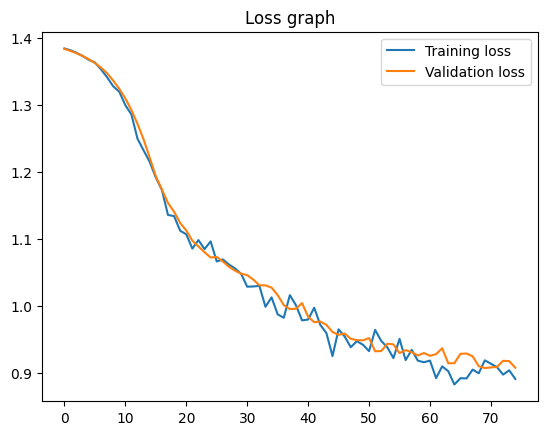

In [63]:
# Plot loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Loss graph")
plt.show()

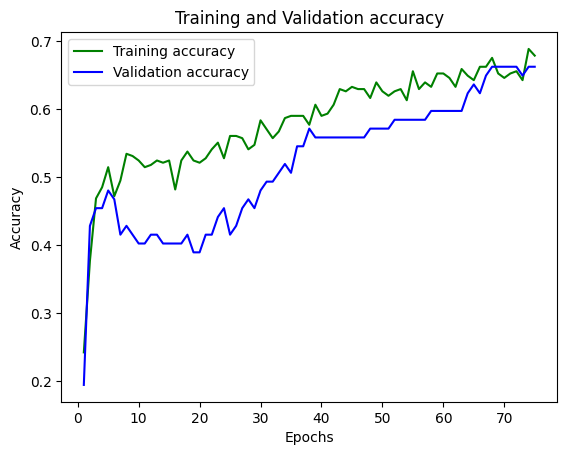

In [64]:
# plot accuracy graph
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,len(accuracy_val) + 1)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model's metrics on 20 datasets

In [20]:
from sklearn.metrics import classification_report

In [21]:
shuffled_df = lagged_data.sample(frac=1, random_state=4)

In [22]:
num_datasets = 20
datasets = np.array_split(shuffled_df, num_datasets)

In [23]:
xscaler = MinMaxScaler(feature_range=(0, 1))

In [24]:
saved_model = tf.keras.models.load_model('bilstm_magnitude_7_day_lag_3_day_window')

In [25]:
saved_model.summary()

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_200 (Bidirect  (None, 3, 148)           47360     
 ional)                                                          
                                                                 
 dropout_200 (Dropout)       (None, 3, 148)            0         
                                                                 
 bidirectional_201 (Bidirect  (None, 148)              132016    
 ional)                                                          
                                                                 
 dropout_201 (Dropout)       (None, 148)               0         
                                                                 
 dense_100 (Dense)           (None, 4)                 596       
                                                                 
Total params: 179,972
Trainable params: 179,972
Non-

In [26]:
micro_precision_list = []
micro_recall_list = []
micro_f1_list = []

macro_precision_list = []
macro_recall_list = []
macro_f1_list = []

weighted_precision_list = []
weighted_recall_list = []
weighted_f1_list = []

samples_precision_list = []
samples_recall_list = []
samples_f1_list = []

In [27]:
for dataset in datasets:
    X = dataset.iloc[:, :total_features].values
    y = dataset['feature1(t)'].values
    X = xscaler.fit_transform(X)
    X = X.reshape((X.shape[0], n_lag, n_features))
    
    y_pred = saved_model.predict(X)
    y_true = keras.utils.to_categorical(y, 4)
    
    max_indices = np.argmax(y_pred, axis=1)
    one_hot_encoded = np.zeros_like(y_pred)
    one_hot_encoded[np.arange(len(y_pred)), max_indices] = 1
    
    report = classification_report(y_true, one_hot_encoded, output_dict=True, zero_division=0)
    
    micro_precision_list.append(report['micro avg']['precision'])
    micro_recall_list.append(report['micro avg']['recall'])
    micro_f1_list.append(report['micro avg']['f1-score'])
    
    macro_precision_list.append(report['macro avg']['precision'])
    macro_recall_list.append(report['macro avg']['recall'])
    macro_f1_list.append(report['macro avg']['f1-score'])
    
    weighted_precision_list.append(report['weighted avg']['precision'])
    weighted_recall_list.append(report['weighted avg']['recall'])
    weighted_f1_list.append(report['weighted avg']['f1-score'])
    
    samples_precision_list.append(report['samples avg']['precision'])
    samples_recall_list.append(report['samples avg']['recall'])
    samples_f1_list.append(report['samples avg']['f1-score'])

1/1 [==============================] - 0s 18ms/step


In [28]:
avg_micro_precision = np.mean(micro_precision_list)
avg_micro_recall = np.mean(micro_recall_list)
avg_micro_f1 = np.mean(micro_f1_list)

avg_macro_precision = np.mean(macro_precision_list)
avg_macro_recall = np.mean(macro_recall_list)
avg_macro_f1 = np.mean(macro_f1_list)

avg_weighted_precision = np.mean(weighted_precision_list)
avg_weighted_recall = np.mean(weighted_recall_list)
avg_weighted_f1 = np.mean(weighted_f1_list)

avg_samples_precision = np.mean(samples_precision_list)
avg_samples_recall = np.mean(samples_recall_list)
avg_samples_f1 = np.mean(samples_f1_list)

In [29]:
print('Micro')
print(f'Average Micro Precision: {avg_micro_precision}')
print(f'Average Micro Recall: {avg_micro_recall}')
print(f'Average Micro F1-score: {avg_micro_f1}')

print('\n\nMacro')
print(f'Average Macro Precision: {avg_macro_precision}')
print(f'Average Macro Recall: {avg_macro_recall}')
print(f'Average Macro F1-score: {avg_macro_f1}')

print('\n\nWeighted')
print(f'Average Weighted Precision: {avg_weighted_precision}')
print(f'Average Weighted Recall: {avg_weighted_recall}')
print(f'Average Weighted F1-score: {avg_weighted_f1}')

print('\n\nSamples')
print(f'Average Samples Precision: {avg_samples_precision}')
print(f'Average Samples Recall: {avg_samples_recall}')
print(f'Average Samples F1-score: {avg_samples_f1}')

Micro
Average Micro Precision: 0.6592885375494072
Average Micro Recall: 0.6592885375494072
Average Micro F1-score: 0.6592885375494072


Macro
Average Macro Precision: 0.6647695707070708
Average Macro Recall: 0.6751339285714286
Average Macro F1-score: 0.6411207073155604


Weighted
Average Weighted Precision: 0.6946543462576071
Average Weighted Recall: 0.6592885375494072
Average Weighted F1-score: 0.6477217380935992


Samples
Average Samples Precision: 0.6592885375494072
Average Samples Recall: 0.6592885375494072
Average Samples F1-score: 0.6592885375494072


In [30]:
data = {
    'micro_precision': micro_precision_list,
    'micro_recall': micro_recall_list,
    'micro_f1': micro_f1_list,
    'macro_precision': macro_precision_list,
    'macro_recall': macro_recall_list,
    'macro_f1': macro_f1_list,
    'weighted_precision': weighted_precision_list,
    'weighted_recall': weighted_recall_list,
    'weighted_f1': weighted_f1_list,
    'samples_precision': samples_precision_list,
    'samples_recall': samples_recall_list,
    'samples_f1': samples_f1_list,
}

In [31]:
metrics_df = pd.DataFrame(data)

In [32]:
metrics_df

,micro_precision,micro_recall,micro_f1,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,samples_precision,samples_recall,samples_f1
0,0.739130,0.739130,0.739130,0.770833,0.781250,0.727922,0.811594,0.739130,0.715302,0.739130,0.739130,0.739130
1,0.782609,0.782609,0.782609,0.806250,0.803571,0.790945,0.815217,0.782609,0.784271,0.782609,0.782609,0.782609
2,0.565217,0.565217,0.565217,0.573214,0.612500,0.576923,0.550621,0.565217,0.541806,0.565217,0.565217,0.565217
3,0.608696,0.608696,0.608696,0.596230,0.587500,0.580637,0.662526,0.608696,0.619949,0.608696,0.608696,0.608696
4,0.782609,0.782609,0.782609,0.584722,0.718750,0.644024,0.650483,0.782609,0.709698,0.782609,0.782609,0.782609
5,0.782609,0.782609,0.782609,0.866071,0.732143,0.739286,0.840062,0.782609,0.757143,0.782609,0.782609,0.782609
6,0.739130,0.739130,0.739130,0.770833,0.789286,0.750271,0.793478,0.739130,0.730049,0.739130,0.739130,0.739130
7,0.608696,0.608696,0.608696,0.613095,0.597917,0.599734,0.622153,0.608696,0.610375,0.608696,0.608696,0.608696
8,0.695652,0.695652,0.695652,0.698864,0.666667,0.647304,0.750988,0.695652,0.685592,0.695652,0.695652,0.695652
9,0.608696,0.608696,0.608696,0.566667,0.568452,0.556232,0.588406,0.608696,0.586262,0.608696,0.608696,0.608696


In [33]:
# Get the minimum value of each column
min_values = metrics_df.min()

# Get the maximum value of each column
max_values = metrics_df.max()

print('Minimum Values:')
print(min_values)

print('\n\nMaximum Values:')
print(max_values)

Minimum Values:
micro_precision       0.500000
micro_recall          0.500000
micro_f1              0.500000
macro_precision       0.489583
macro_recall          0.486905
macro_f1              0.486111
weighted_precision    0.494318
weighted_recall       0.500000
weighted_f1           0.494949
samples_precision     0.500000
samples_recall        0.500000
samples_f1            0.500000
dtype: float64


Maximum Values:
micro_precision       0.782609
micro_recall          0.782609
micro_f1              0.782609
macro_precision       0.866071
macro_recall          0.833333
macro_f1              0.790945
weighted_precision    0.840062
weighted_recall       0.782609
weighted_f1           0.784271
samples_precision     0.782609
samples_recall        0.782609
samples_f1            0.782609
dtype: float64


In [34]:
metrics_df.to_csv('metrics/BiLSTM magnitude 7 day lag 3 day window.csv', index=False)